<a href="https://colab.research.google.com/github/Ansebi/Game_Of_Life/blob/main/20221210_Game_Of_Life.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Startup

SQUARE FIELD

0 - dead cell<br>
1 - live cell<br>

In [2]:
!pip install livelossplot --quiet

In [3]:
from livelossplot import PlotLossesKeras

In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
import time

In [5]:
SHEET_ID = '1OdllC9j05ka_adHvipTn58XPqmLt5f1VLBzHFd9aRJQ'
SHEET_NAME = 'GoL'
SLEEP = 1.5

In [6]:
def load_board(sheet_id, sheet_name, show=False):
  google_sheets_url = 'https://docs.google.com/spreadsheets/d/'
  google_sheets_url += f'{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
  board = pd.read_csv(google_sheets_url, header=None)
  if show:
    plt.imshow(board)
    plt.title('Step 0.')
    plt.show()
  return board

In [7]:
def get_filter_coords(point_coords):
  """
  x0y0 xiy0 x2y0
  x0yi xiyi x2yi
  x0y2 xiy2 x2y2
  """
  xi, yi = point_coords

  x0 = xi - 1
  x2 = xi + 1
  y0 = yi - 1
  y2 = yi + 1

  ul = (x0, y0)  # upper left
  uc = (xi, y0)  # upper center
  ur = (x2, y0)  # upper right
  ml = (x0, yi)  # middle left
  #mc = (xi, yi)  # middle center
  mr = (x2, yi)  # middle right
  ll = (x0, y2)  # lower left
  lc = (xi, y2)  # lower center
  lr = (x2, y2)  # lower right

  filter_coords = ul, uc, ur, ml, mr, ll, lc, lr
  
  return filter_coords

In [8]:
def read_coord(board, coord):
  shape_y, shape_x = board.shape
  xi, yi = coord
  if (xi < 0) or (yi < 0):
    return 0
  if (xi >= shape_x) or (yi >= shape_y):
    return 0
  return board[xi][yi]

In [9]:
def read_filter(board, filter_coords):
  for coord in filter_coords:
    yield read_coord(board, coord)

In [10]:
"""
Any live cell with fewer than two live neighbours dies, as if by underpopulation.
Any live cell with two or three live neighbours lives on to the next generation.
Any live cell with more than three live neighbours dies, as if by overpopulation.
Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.
These rules, which compare the behavior of the automaton to real life, can be condensed into the following:
OR
Any live cell with two or three live neighbours survives.
Any dead cell with three live neighbours becomes a live cell.
All other live cells die in the next generation. Similarly, all other dead cells stay dead.
"""

'\nAny live cell with fewer than two live neighbours dies, as if by underpopulation.\nAny live cell with two or three live neighbours lives on to the next generation.\nAny live cell with more than three live neighbours dies, as if by overpopulation.\nAny dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.\nThese rules, which compare the behavior of the automaton to real life, can be condensed into the following:\nOR\nAny live cell with two or three live neighbours survives.\nAny dead cell with three live neighbours becomes a live cell.\nAll other live cells die in the next generation. Similarly, all other dead cells stay dead.\n'

In [11]:
def play_a_cell(board, cell_coords):  
  initial_state = read_coord(board, cell_coords)
  filter_coords = get_filter_coords(cell_coords)
  sum_neighbours = sum(read_filter(board, filter_coords))
  if sum_neighbours == 3:
    return 1
  if sum_neighbours == 2:
    return initial_state
  return 0

In [12]:
def play(board, padding=0, show=False) -> pd.DataFrame:
  shape_y, shape_x = board.shape
  result  = pd.DataFrame(
      np.zeros((shape_y-2*padding, shape_x-2*padding), dtype=int)
      )
  for xi in range(padding, shape_x-padding):
    for yi in range(padding, shape_y-padding):
      result[xi-padding][yi-padding] = play_a_cell(board, [xi, yi])
  if show:
    plt.imshow(result)
    plt.title(f'Board {board.shape}, {padding=}.')
    plt.show()
  return result

In [13]:
training_list = []

In [14]:
def recursive_play(board, limit, current_step=0, show=True, ret=True, results=[]):
  current_step += 1 
  result = play(board)
  if show:
    plt.imshow(result)
    plt.title(f'Step {current_step}.')
    plt.show()
    time.sleep(SLEEP)
    clear_output()
  if current_step == limit:
    training_list.append([board, result])
  if current_step < limit:
    recursive_play(result, limit, show=show, current_step=current_step, results=results)

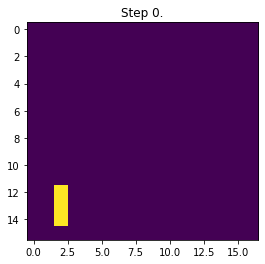

In [15]:
board = load_board(SHEET_ID, SHEET_NAME, show=True)

In [16]:
recursive_play(board, 5, show=True)

# Linear Sequence

In [ ]:
class LinearSequence(tf.keras.utils.Sequence):

    def __init__(self, limit, batch_size):
        self.limit = limit
        self.batch_size = batch_size

    def __len__(self):
        return np.ceil(self.limit / self.batch_size).astype(int)

    def __getitem__(self, idx):
        batch_x = np.arange(idx, idx+self.batch_size).reshape(-1, 1)
        batch_y = batch_x * 2 + np.random.rand(self.batch_size).reshape(-1, 1)
        batch_y = np.tile(batch_y, (1,3))
        # print(batch_x)
        # print('\n'*5)
        # print(batch_y)
        return batch_x, batch_y

x_shape = LinearSequence(limit=100, batch_size=1).__getitem__(0)[0].shape
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
input_layer = tf.keras.layers.Input(x_shape)
linear_model = tf.keras.models.Sequential([
    input_layer,
    tf.keras.layers.Dense(3),
])
linear_model.compile(optimizer=adam, loss='mae')
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 3)              6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [ ]:
linear_model.fit(LinearSequence(limit=100, batch_size=1), epochs=50, verbose=False)
linear_model.predict([[5000]])

1/1 [==============================] - 0s 105ms/step


array([[[10004.3125, 10001.986 ,  9988.862 ]]], dtype=float32)

# Binary

In [ ]:
def to_binarray(int_, w=16):
  return np.array(list(np.binary_repr(int_, width=w))).astype(int)

In [ ]:
class BinarySequence(tf.keras.utils.Sequence):

    def __init__(self, limit, batch_size):
        self.limit = limit
        self.batch_size = batch_size

    def __len__(self):
        return np.ceil(self.limit / self.batch_size).astype(int)

    def __getitem__(self, idx):
        batch_x = np.arange(idx, idx+self.batch_size)#.reshape(-1, 1)
        batch_y = batch_x % 2
        batch_x = np.array(
            [to_binarray(i) for i in batch_x]
            )
        batch_y = np.array(
            [tf.keras.utils.to_categorical(i, num_classes=2).astype(bool) for i in batch_y]
            )
        return batch_x, batch_y

BATCH_SIZE = 1
x_shape = BinarySequence(limit=200, batch_size=BATCH_SIZE).__getitem__(0)[0].shape[1]
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
input_layer = tf.keras.layers.Input(x_shape)
binary_model = tf.keras.models.Sequential([
    input_layer,
    #tf.keras.layers.Dense(1, activation='ReLU'),
    tf.keras.layers.Dense(2, activation='sigmoid'),
])
binary_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
binary_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [ ]:
binary_model.fit(
    BinarySequence(
        limit=200,
        batch_size=BATCH_SIZE),
    epochs=10,
    verbose=True
    )

Epoch 1/10
200/200 [==============================] - 1s 2ms/step - loss: 0.6124 - accuracy: 0.7650
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3866 - accuracy: 1.0000
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 1.0000
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 1.0000
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1375 - accuracy: 1.0000
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1057 - accuracy: 1.0000
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0839 - accuracy: 1.0000
Epoch 8/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 1.0000
Epoch 9/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 1.0000
Epoch 10/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 1.0000

In [ ]:
def binary_get_pred(binary_model, sequence):
  raw_pred = binary_model.predict(np.array([to_binarray(i) for i in sequence]))
  pred = np.argmax(raw_pred, axis=1)
  return pred

In [ ]:
binary_get_pred(binary_model, [2000, 3000, 3001])

1/1 [==============================] - 0s 135ms/step


array([0, 0, 1])

# Common

In [58]:
def generate_board(shape, padding=False, pad_value=0, levels=5, regulate_extreme_cases=False, show=False):
  """
  'outer' padding surrounds the array with zeros explicitly
  the shape of the board changes (+2 to each dimension)
  padding at conv2d layer is meant to be set to 'valid'
  """
  if levels:
    choice_ = np.random.randint(0, 1+1, levels)
    if regulate_extreme_cases:
      choice_ = np.concatenate([[0, 1], choice_])
    rand_array = np.random.choice(choice_, shape)
  else:
    rand_array = np.random.randint(0, 1+1, shape)
  if padding:
    assert padding == 'outer', 'padding must be either "outer" or None'
  if padding == 'outer':
    rand_array = np.pad(rand_array, 1, mode='constant', constant_values=pad_value)
  rand_board = pd.DataFrame(rand_array)
  if show:
    plt.imshow(rand_board)
    plt.title(f'Randomized board {shape}, {levels=}, {regulate_extreme_cases=}.')
    plt.show()
  return rand_board

In [18]:
def interpret_categorical(categorical_array, show=False) -> pd.DataFrame:
  result = []
  if len(categorical_array) > 1:
    for i in categorical_array:
      result.append(np.argmax(i, axis=1))    
  else:
    result = np.argmax(categorical_array, axis=1)
  result = pd.DataFrame(result) 
  if show:
    plt.imshow(result)
    plt.title(f'Board {board.shape}.')
    plt.show()
  return result

In [19]:
def interpret_categorical_batch(categorical_batch, show=False):
  result = []
  for categorical_array in categorical_batch:
    result.append(
        interpret_categorical(
            categorical_array,
            show=show
            )
        )
  return np.array(result)

## TEST

In [ ]:
BATCH_SIZE = 100

In [20]:
class GameOfLifeXYGenerator(tf.keras.utils.Sequence):

  def __init__(
    self,
    batch_size,
    board_padding=False,
    pad_value=0,
    board_shape=(3, 3),
    levels=5,
    regulate_extreme_cases=False,
    play_padding=0
    ):
    self.batch_size = batch_size
    self.board_shape = board_shape
    self.board_padding = board_padding
    self.pad_value = pad_value
    self.levels = levels
    self.regulate_extreme_cases = regulate_extreme_cases
    self.play_padding = play_padding

  def __len__(self):
    return 1#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x = []
    batch_y = []
    for i in range(self.batch_size):
      xi = generate_board(
          shape=self.board_shape,
          padding=self.board_padding,
          pad_value=self.pad_value,
          levels=self.levels,
          regulate_extreme_cases=self.regulate_extreme_cases
          )
      yi = play(xi, padding=self.play_padding)
      yi = tf.keras.utils.to_categorical(yi, num_classes=2).astype(int)
      batch_x.append(xi)
      batch_y.append(yi)    
    return np.array(batch_x), np.array(batch_y)

In [ ]:
input_shape = GameOfLifeXYGenerator(batch_size=BATCH_SIZE).__getitem__(0)[0].shape
print(input_shape)

input_layer = tf.keras.layers.Input(input_shape[1:])
dense_9a = tf.keras.layers.Dense(9, activation='ReLU')(input_layer)
dense_9b = tf.keras.layers.Dense(9, activation='ReLU')(input_layer)
dense_1a = tf.keras.layers.Dense(1, activation='ReLU')(dense_9a)
dense_1b = tf.keras.layers.Dense(1, activation='ReLU')(dense_9b)
ab = tf.keras.layers.Concatenate()([dense_9a, dense_9b])
dense_2ab = tf.keras.layers.Dense(2, activation='sigmoid')(ab)
model = tf.keras.models.Model(inputs=input_layer, outputs=dense_2ab)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(
  optimizer=adam,
  loss='binary_crossentropy',
  metrics=['accuracy']
)
model.summary()
tf.keras.utils.plot_model(model)

#TEST EXAMPLE

In [ ]:
x0, y0 = GameOfLifeXYGenerator(
    batch_size=2,
    board_shape=(3,3),
    board_padding=False,
    levels=0,
    regulate_extreme_cases=False,
    play_padding=1
    ).__getitem__(0)
x0

array([[[1, 1, 1],
        [0, 1, 1],
        [1, 0, 0]],

       [[0, 1, 1],
        [0, 0, 0],
        [1, 0, 1]]])

In [ ]:
y0

array([[[1, 0]],

       [[1, 0]]])

In [ ]:
interpret_categorical_batch(y0)

array([[[0]],

       [[0]]])

#FURTHER TEST

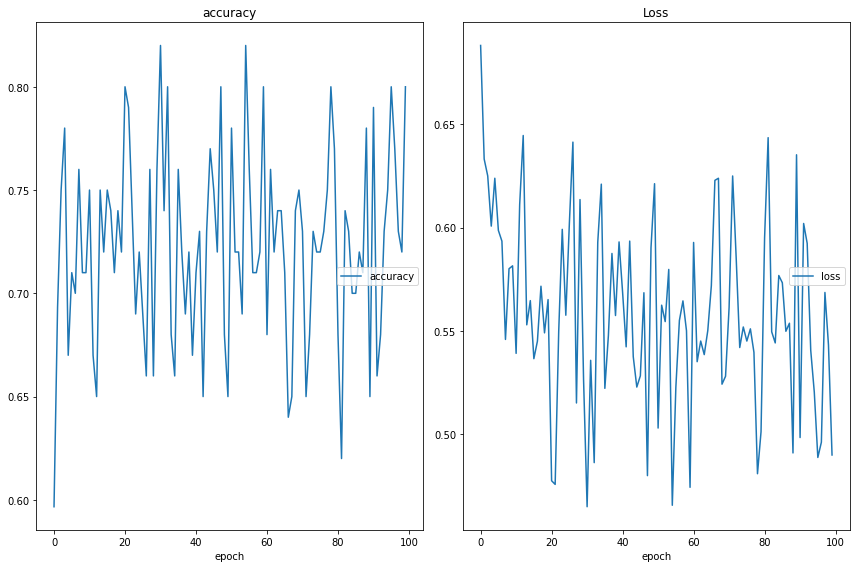

accuracy
	accuracy         	 (min:    0.597, max:    0.820, cur:    0.800)
Loss
	loss             	 (min:    0.465, max:    0.688, cur:    0.490)
1/1 [==============================] - 0s 475ms/step - loss: 0.4901 - accuracy: 0.8000


In [ ]:
model.fit(
    GameOfLifeXYGenerator(
        batch_size=BATCH_SIZE,
        board_shape=(3,3),
        board_padding=False,
        levels=0,
        regulate_extreme_cases=False,
        play_padding=1
        ),
    epochs=100,
    verbose=True,
    callbacks=[PlotLossesKeras()]
    )

In [ ]:
model.get_weights()

[array([[ 0.36196685, -0.4851856 , -0.25870636,  0.16935995,  0.2055125 ,
          0.87762004,  0.02871262,  0.10906138,  0.43668872],
        [ 0.29448485,  0.30944133,  0.7046712 ,  0.21072833,  0.49064305,
          0.03583028, -0.46464178, -0.3503326 ,  0.35699356],
        [-0.6616297 ,  0.27659836,  0.731066  ,  0.12620324, -0.0216478 ,
          0.84081364,  0.25086182,  0.18256593, -0.00330949]],
       dtype=float32),
 array([-0.00142524, -0.06991187,  0.13521712, -0.20274578,  0.04767365,
         0.05032928, -0.11175717,  0.05540621, -0.10538488], dtype=float32),
 array([[-0.7159587 ,  0.4040357 ,  0.31327423,  0.5422283 ,  0.48458955,
         -0.60031575, -0.58476806, -0.3028499 , -0.36712772],
        [ 0.1307472 ,  0.5366069 , -0.3598572 ,  0.05910197,  0.6029882 ,
         -0.5158154 ,  0.43050495, -0.58963543,  0.26503128],
        [ 0.5476762 ,  0.00165087, -0.14676176,  0.11519386,  0.5169736 ,
         -0.29462266, -0.18074442, -0.38719332, -0.5667615 ]],
       dt

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1)
model.compile(
  optimizer=adam,
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [ ]:
model.get_weights()

[array([[ 0.36196685, -0.4851856 , -0.25870636,  0.16935995,  0.2055125 ,
          0.87762004,  0.02871262,  0.10906138,  0.43668872],
        [ 0.29448485,  0.30944133,  0.7046712 ,  0.21072833,  0.49064305,
          0.03583028, -0.46464178, -0.3503326 ,  0.35699356],
        [-0.6616297 ,  0.27659836,  0.731066  ,  0.12620324, -0.0216478 ,
          0.84081364,  0.25086182,  0.18256593, -0.00330949]],
       dtype=float32),
 array([-0.00142524, -0.06991187,  0.13521712, -0.20274578,  0.04767365,
         0.05032928, -0.11175717,  0.05540621, -0.10538488], dtype=float32),
 array([[-0.7159587 ,  0.4040357 ,  0.31327423,  0.5422283 ,  0.48458955,
         -0.60031575, -0.58476806, -0.3028499 , -0.36712772],
        [ 0.1307472 ,  0.5366069 , -0.3598572 ,  0.05910197,  0.6029882 ,
         -0.5158154 ,  0.43050495, -0.58963543,  0.26503128],
        [ 0.5476762 ,  0.00165087, -0.14676176,  0.11519386,  0.5169736 ,
         -0.29462266, -0.18074442, -0.38719332, -0.5667615 ]],
       dt

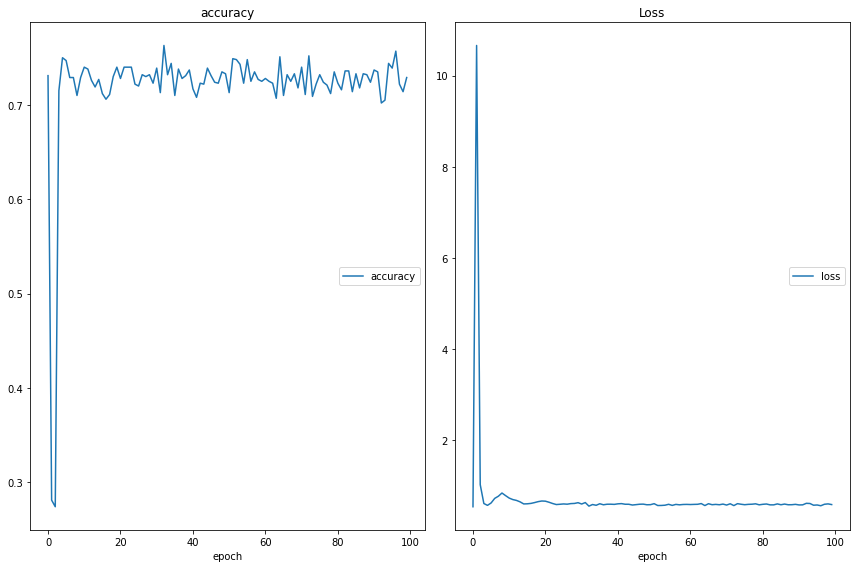

accuracy
	accuracy         	 (min:    0.274, max:    0.763, cur:    0.729)
Loss
	loss             	 (min:    0.537, max:   10.663, cur:    0.584)
1/1 [==============================] - 1s 1s/step - loss: 0.5843 - accuracy: 0.7290


In [ ]:
model.fit(
    GameOfLifeXYGenerator(
        batch_size=1000,
        board_shape=(3,3),
        board_padding=False,
        levels=0,
        regulate_extreme_cases=False,
        play_padding=1
        ),
    epochs=100,
    verbose=True,
    callbacks=[PlotLossesKeras()]
    )

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model1.hdf5',
    monitor = 'accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)

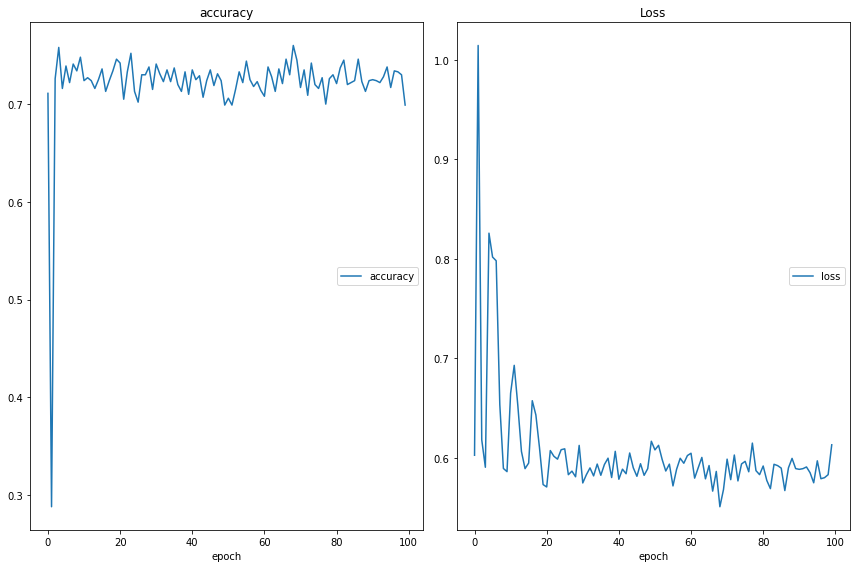

accuracy
	accuracy         	 (min:    0.288, max:    0.760, cur:    0.699)
Loss
	loss             	 (min:    0.551, max:    1.014, cur:    0.613)

Epoch 100: accuracy did not improve from 0.76000
1/1 [==============================] - 1s 1s/step - loss: 0.6133 - accuracy: 0.6990


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=2)
model.compile(
  optimizer=adam,
  loss='binary_crossentropy',
  metrics=['accuracy']
)
model.fit(
    GameOfLifeXYGenerator(
        batch_size=1000,
        board_shape=(3,3),
        board_padding=False,
        levels=0,
        regulate_extreme_cases=False,
        play_padding=1
        ),
    epochs=100,
    verbose=True,
    callbacks=[
        PlotLossesKeras(),
        checkpoint
        ]
    )

In [ ]:
model.load_weights('model1.hdf5')

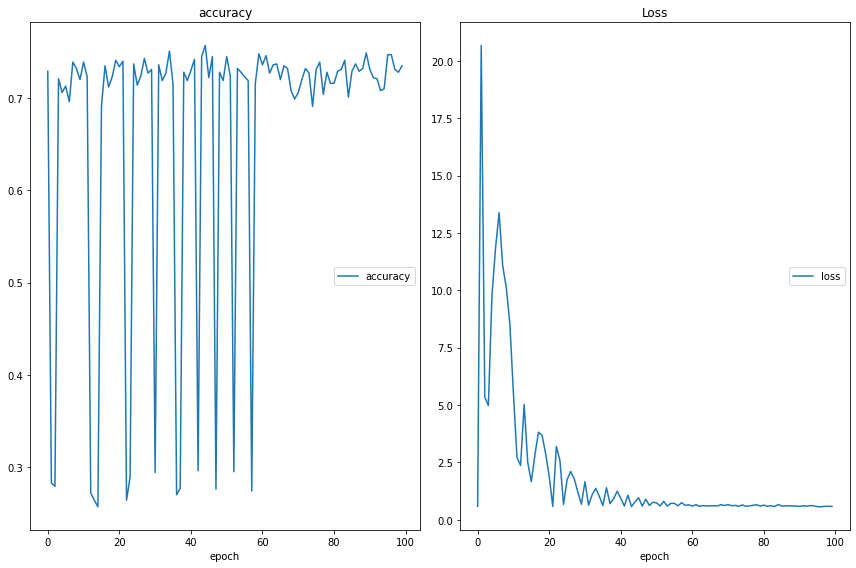

accuracy
	accuracy         	 (min:    0.257, max:    0.757, cur:    0.735)
Loss
	loss             	 (min:    0.566, max:   20.677, cur:    0.578)

Epoch 100: accuracy did not improve from 0.76000
1/1 [==============================] - 1s 1s/step - loss: 0.5782 - accuracy: 0.7350


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=30)
model.compile(
  optimizer=adam,
  loss='binary_crossentropy',
  metrics=['accuracy']
)
model.fit(
    GameOfLifeXYGenerator(
        batch_size=1000,
        board_shape=(3,3),
        board_padding=False,
        levels=0,
        regulate_extreme_cases=False,
        play_padding=1
        ),
    epochs=100,
    verbose=True,
    callbacks=[
        PlotLossesKeras(),
        checkpoint
        ]
    )

#TEST_TEST

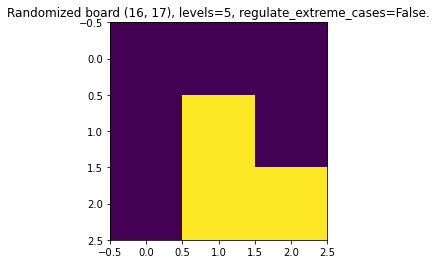

In [ ]:
x1 = np.array(generate_board((3,3), show=True))[None, ...]

In [ ]:
x1

array([[[0, 0, 0],
        [0, 1, 0],
        [0, 1, 1]]])

In [ ]:
x1.shape

(1, 3, 3)

In [ ]:
model.predict(x1)

1/1 [==============================] - 0s 30ms/step


array([[[0.5       , 0.5       ],
        [0.37030643, 0.5535485 ],
        [0.36611614, 0.48493904]]], dtype=float32)

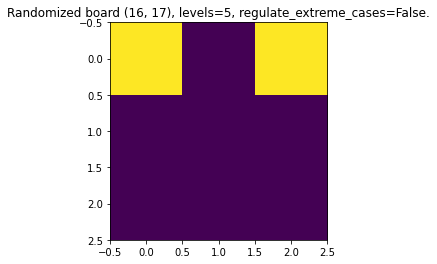

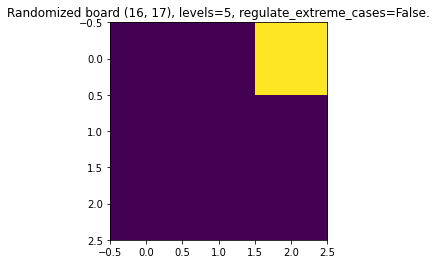

1/1 [==============================] - 0s 20ms/step


array([[[0.51998943, 0.40727028],
        [0.5       , 0.5       ],
        [0.5       , 0.5       ]],

       [[0.4992703 , 0.42289165],
        [0.5       , 0.5       ],
        [0.5       , 0.5       ]]], dtype=float32)

In [ ]:
model.predict(np.array([
    generate_board((3,3), show=True),
    generate_board((3,3), show=True),
    ]))

In [ ]:
interpret_categorical(model.predict(x1), show=False)

1/1 [==============================] - 0s 20ms/step


AxisError: ignored

In [ ]:
cat_x1 = tf.keras.utils.to_categorical(x1, num_classes=2).astype(int)
batch_x1 = np.array([cat_x1])
inp_lyr = tf.keras.layers.Input(shape=(3,3,2))
c2d_lyr = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=1)(inp_lyr)
model = tf.keras.models.Model(inputs=inp_lyr, outputs=c2d_lyr)
model.trainable = False
model.build(input_shape=(3,3,2))
model(batch_x1)

<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[-2.8822203]]]], dtype=float32)>

In [ ]:
cat_x1.shape

(3, 3, 2)

In [ ]:
batch_x1.shape

(1, 3, 3, 2)

In [ ]:
batch_x1

array([[[[1, 0],
         [0, 1],
         [0, 1]],

        [[0, 1],
         [1, 0],
         [0, 1]],

        [[0, 1],
         [0, 1],
         [1, 0]]]])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 3, 2)]         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 1)           19        
                                                                 
Total params: 19
Trainable params: 0
Non-trainable params: 19
_________________________________________________________________


array([[[[0.],
         [1.],
         [1.]],

        [[1.],
         [0.],
         [1.]],

        [[1.],
         [1.],
         [0.]]]])

# Conv2D vs GameOfLifeXY inputs

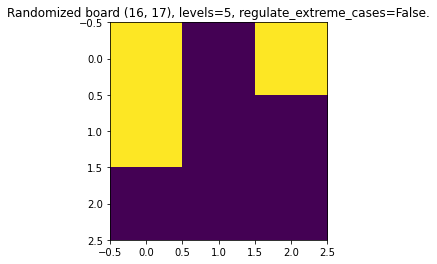

In [ ]:
x1 = generate_board((3,3), show=True)

In [ ]:
test_c2d_layer = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=1)
test_c2d_layer(np.array(x1)[None, ..., None].astype(float))
test_c2d_layer.get_weights()

[array([[[[-0.16493636]],
 
         [[-0.4177721 ]],
 
         [[-0.15932032]]],
 
 
        [[[ 0.09776235]],
 
         [[ 0.4012493 ]],
 
         [[-0.52422285]]],
 
 
        [[[-0.5021456 ]],
 
         [[ 0.42941427]],
 
         [[-0.4250339 ]]]], dtype=float32), array([0.], dtype=float32)]

In [ ]:
test_c2d_layer = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=2)
test_c2d_layer(np.array(x1)[None, ..., None].astype(float))
test_c2d_layer.get_weights()

[array([[[[-0.11977854,  0.13079181]],
 
         [[ 0.18539366, -0.3641855 ]],
 
         [[-0.36972195, -0.43197453]]],
 
 
        [[[-0.12957862,  0.06108877]],
 
         [[ 0.07271019,  0.3091295 ]],
 
         [[ 0.1528717 , -0.29406488]]],
 
 
        [[[ 0.32453838, -0.14649424]],
 
         [[-0.29257792, -0.10741109]],
 
         [[-0.13235763, -0.29567295]]]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [ ]:
test_weights = np.array([
    np.array([
    [ [[1, 0]], [[1, 0]], [[1, 0]] ],
    [ [[1, 0]], [[0, 1]], [[1, 0]] ],
    [ [[1, 0]], [[1, 0]], [[1, 0]] ]
    ]),
    np.array([0., 0.])
    ],
    dtype=object
)

In [ ]:
test_c2d_layer.set_weights(test_weights)

In [ ]:
test_c2d_layer(np.array(x1)[None, ..., None].astype(float))

<tf.Tensor: shape=(1, 1, 1, 2), dtype=float32, numpy=array([[[[3., 0.]]]], dtype=float32)>

# Nonlinear generator

In [ ]:
class NonlinearGenerator(tf.keras.utils.Sequence):

  def __init__(self):
    pass

  def __len__(self):
    return 1#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x = []
    batch_y = []
    for xi in range(9):
      yi = 1 if xi in [2, 3] else 0
      batch_x.append(xi)
      batch_y.append(yi)    
    return np.array(batch_x), np.array(batch_y)

In [ ]:
NonlinearGenerator().__getitem__(0)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 0, 1, 1, 0, 0, 0, 0, 0]))

In [ ]:
nonlinear_model = tf.keras.models.Sequential(
    tf.keras.layers.Dense(1, input_shape=[1,])
)
adam.learning_rate = 1
nonlinear_model.compile(loss='mse', optimizer=adam)
nonlinear_model.fit(NonlinearGenerator(), epochs=100)
nonlinear_model.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
nonlinear_model_2 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,]),
    tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_2.compile(loss='mse', optimizer=adam)
nonlinear_model_2.fit(NonlinearGenerator(), epochs=100)
nonlinear_model_2.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
adam.learning_rate = 0.1
nonlinear_model_2.compile(loss='mse', optimizer=adam)
nonlinear_model_2.fit(NonlinearGenerator(), epochs=1000, verbose=False)
nonlinear_model_2.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

1/1 [==============================] - 0s 66ms/step


array([[0.42222232],
       [0.37222213],
       [0.3222229 ],
       [0.27222365],
       [0.2222225 ],
       [0.17222136],
       [0.12222403],
       [0.07222098],
       [0.02222556]], dtype=float32)

In [ ]:
np.round(nonlinear_model_2.predict([0, 1, 2, 3, 4, 5, 6, 7, 8]))

1/1 [==============================] - 0s 82ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
nonlinear_model_3 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,]),
     tf.keras.layers.Dense(2, input_shape=[1,]),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_3.compile(loss='mse', optimizer=adam)
nonlinear_model_3.fit(NonlinearGenerator(), epochs=100)
nonlinear_model_3.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
adam.learning_rate = 0.1
nonlinear_model_3.compile(loss='mse', optimizer=adam)
nonlinear_model_3.fit(NonlinearGenerator(), epochs=100)
nonlinear_model_3.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

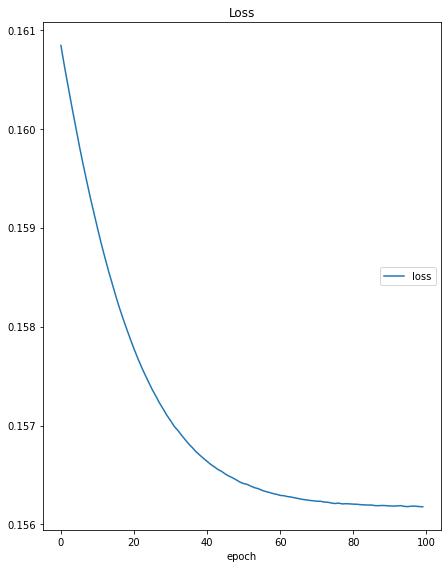

Loss
	loss             	 (min:    0.156, max:    0.161, cur:    0.156)
1/1 [==============================] - 0s 72ms/step


array([[0.41719627],
       [0.36820793],
       [0.31920433],
       [0.27020836],
       [0.22119713],
       [0.1721859 ],
       [0.12318993],
       [0.07420921],
       [0.02516747]], dtype=float32)

In [ ]:
adam.learning_rate = 0.1
nonlinear_model_3.compile(loss='mse', optimizer=adam)
nonlinear_model_3.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_3.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

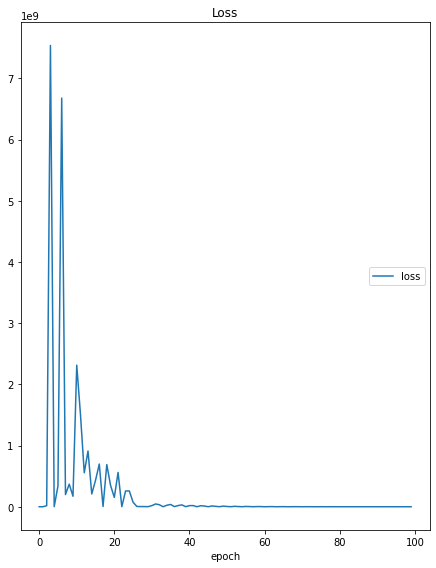

Loss
	loss             	 (min:    2.331, max: 7537478144.000, cur: 43732.922)
1/1 [==============================] - 0s 75ms/step


array([[   9.697132],
       [ -15.218639],
       [ -40.13441 ],
       [ -65.050186],
       [ -89.964005],
       [-114.88051 ],
       [-139.79457 ],
       [-164.7101  ],
       [-189.62416 ]], dtype=float32)

In [ ]:
nonlinear_model_4 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(15, input_shape=[1,]),
     tf.keras.layers.Dense(15, input_shape=[1,]),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_4.compile(loss='mse', optimizer=adam)
nonlinear_model_4.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_4.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
adam.learning_rate = 0.1
nonlinear_model_4.compile(loss='mse', optimizer=adam)
nonlinear_model_4.fit(NonlinearGenerator(), epochs=1000, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_4.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

KeyboardInterrupt: ignored

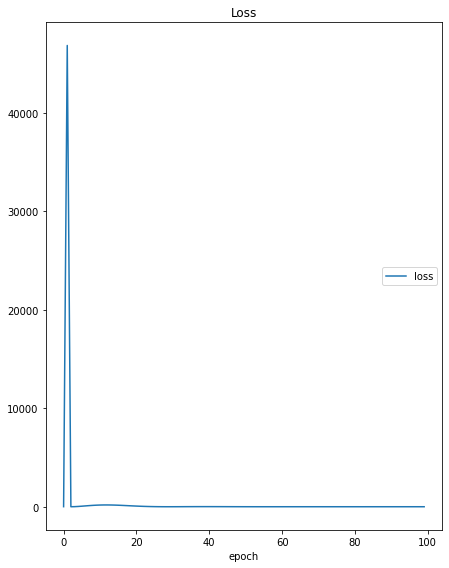

Loss
	loss             	 (min:    0.173, max: 46857.141, cur:    0.191)
1/1 [==============================] - 0s 82ms/step


array([[0.3423757],
       [0.3423757],
       [0.3423757],
       [0.3423757],
       [0.3423757],
       [0.3423757],
       [0.3423757],
       [0.3423757],
       [0.3423757]], dtype=float32)

In [ ]:
nonlinear_model_5 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(15, input_shape=[1,], activation='relu'),
     tf.keras.layers.Dense(15, activation='relu'),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_5.compile(loss='mse', optimizer=adam)
nonlinear_model_5.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_5.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

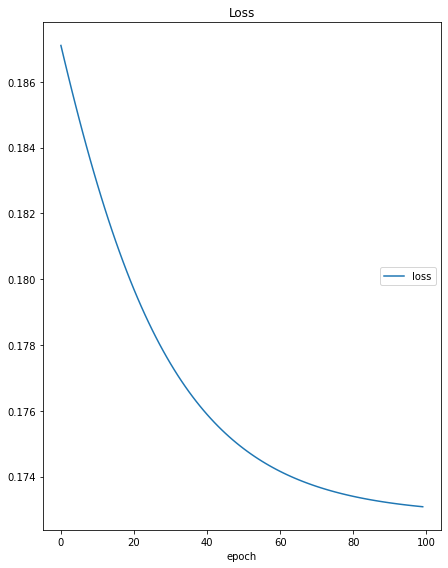

Loss
	loss             	 (min:    0.173, max:    0.187, cur:    0.173)
1/1 [==============================] - 0s 73ms/step


array([[0.23757963],
       [0.23757963],
       [0.23757963],
       [0.23757963],
       [0.23757963],
       [0.23757963],
       [0.23757963],
       [0.23757963],
       [0.23757963]], dtype=float32)

In [ ]:
adam.learning_rate = 0.1
nonlinear_model_5.compile(loss='mse', optimizer=adam)
nonlinear_model_5.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_5.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

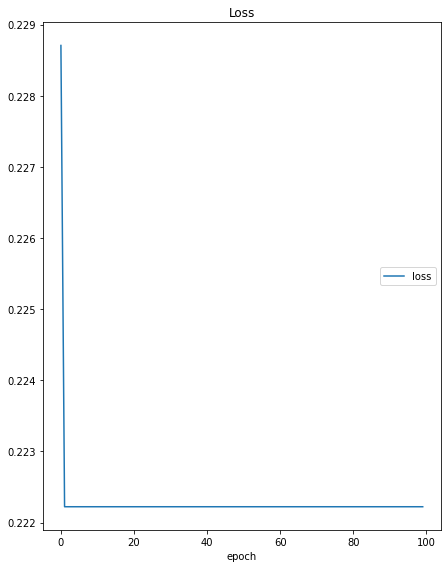

Loss
	loss             	 (min:    0.222, max:    0.229, cur:    0.222)
1/1 [==============================] - 0s 85ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
nonlinear_model_6 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')])
adam.learning_rate = 1
nonlinear_model_6.compile(loss='mse', optimizer=adam)
nonlinear_model_6.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_6.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

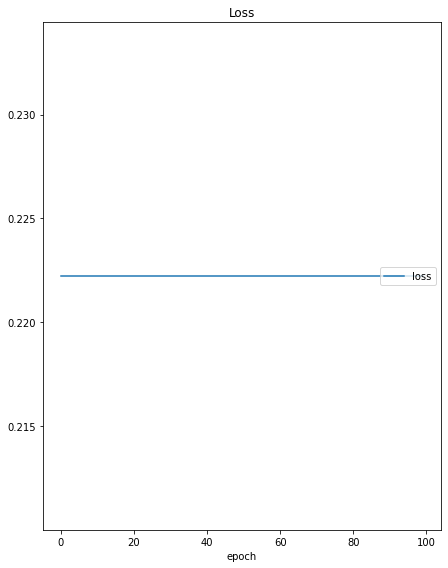

Loss
	loss             	 (min:    0.222, max:    0.222, cur:    0.222)
1/1 [==============================] - 0s 62ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
adam.learning_rate = 0.1
nonlinear_model_6.compile(loss='mse', optimizer=adam)
nonlinear_model_6.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_6.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

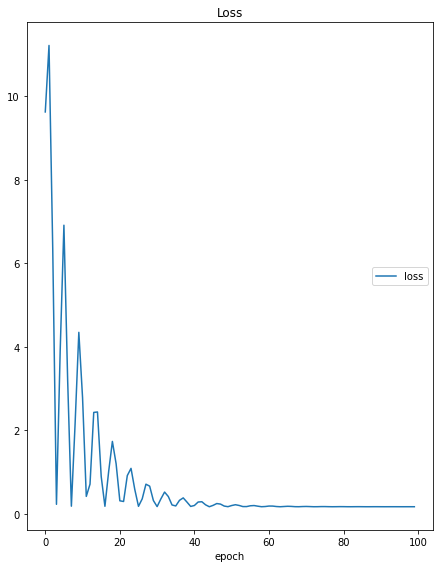

Loss
	loss             	 (min:    0.173, max:   11.218, cur:    0.173)
1/1 [==============================] - 0s 65ms/step


array([[0.22712505],
       [0.22712505],
       [0.22712505],
       [0.22712505],
       [0.22712505],
       [0.22712505],
       [0.22712505],
       [0.22712505],
       [0.22712505]], dtype=float32)

In [ ]:
nonlinear_model_7 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='relu'),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_7.compile(loss='mse', optimizer=adam)
nonlinear_model_7.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_7.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

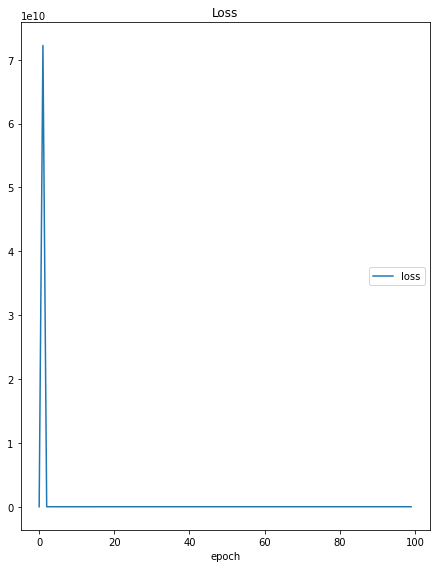

Loss
	loss             	 (min:    0.283, max: 72241684480.000, cur:  712.126)
1/1 [==============================] - 0s 78ms/step


array([[26.901112],
       [26.901112],
       [26.901112],
       [26.901112],
       [26.901112],
       [26.901112],
       [26.901112],
       [26.901112],
       [26.901112]], dtype=float32)

In [ ]:
nonlinear_model_8 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(300, input_shape=[1,], activation='relu'),
     tf.keras.layers.Dense(100, activation='relu'),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_8.compile(loss='mse', optimizer=adam)
nonlinear_model_8.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_8.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

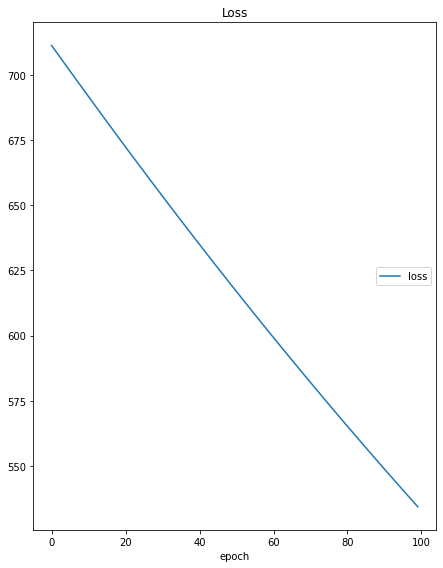

Loss
	loss             	 (min:  534.349, max:  711.351, cur:  534.349)
1/1 [==============================] - 0s 72ms/step


array([[23.30016],
       [23.30016],
       [23.30016],
       [23.30016],
       [23.30016],
       [23.30016],
       [23.30016],
       [23.30016],
       [23.30016]], dtype=float32)

In [ ]:
adam.learning_rate = 10
nonlinear_model_8.compile(loss='mse', optimizer=adam)
nonlinear_model_8.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_8.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

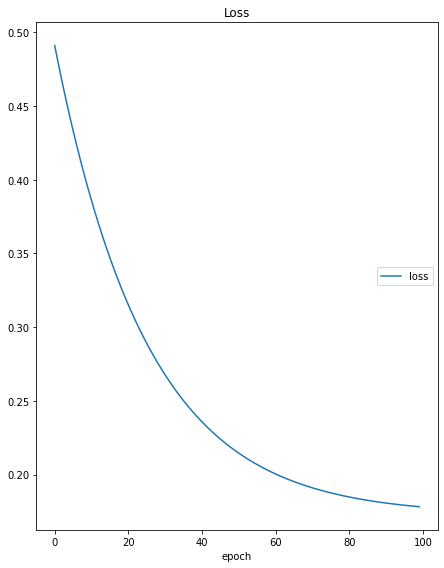

Loss
	loss             	 (min:    0.178, max:    0.491, cur:    0.178)
1/1 [==============================] - 0s 70ms/step


array([[0.2934672],
       [0.2934672],
       [0.2934672],
       [0.2934672],
       [0.2934672],
       [0.2934672],
       [0.2934672],
       [0.2934672],
       [0.2934672]], dtype=float32)

In [ ]:
adam.learning_rate = 100
nonlinear_model_8.compile(loss='mse', optimizer=adam)
nonlinear_model_8.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_8.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

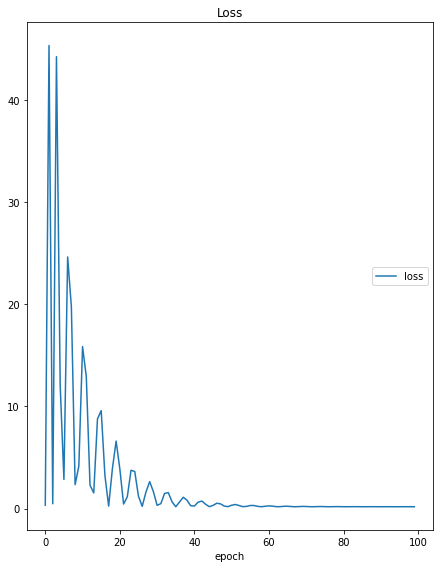

Loss
	loss             	 (min:    0.173, max:   45.322, cur:    0.173)
1/1 [==============================] - 0s 73ms/step


array([[0.19669724],
       [0.19669724],
       [0.19669724],
       [0.19669724],
       [0.19669724],
       [0.19669724],
       [0.19669724],
       [0.19669724],
       [0.19669771]], dtype=float32)

In [ ]:
nonlinear_model_9 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='tanh'),
     tf.keras.layers.Dense(3, activation='softmax'),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_9.compile(loss='mse', optimizer=adam)
nonlinear_model_9.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_9.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

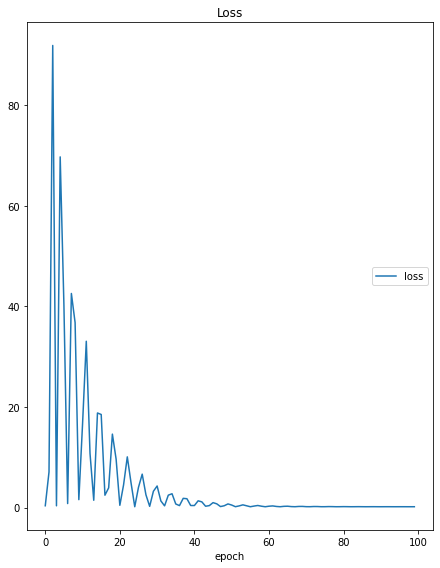

Loss
	loss             	 (min:    0.173, max:   91.847, cur:    0.175)
1/1 [==============================] - 0s 65ms/step


array([[0.17431188],
       [0.17431188],
       [0.17431188],
       [0.17431188],
       [0.17431188],
       [0.17431188],
       [0.17431188],
       [0.17431188],
       [0.17431188]], dtype=float32)

In [ ]:
nonlinear_model_10 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='tanh'),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_10.compile(loss='mse', optimizer=adam)
nonlinear_model_10.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_10.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

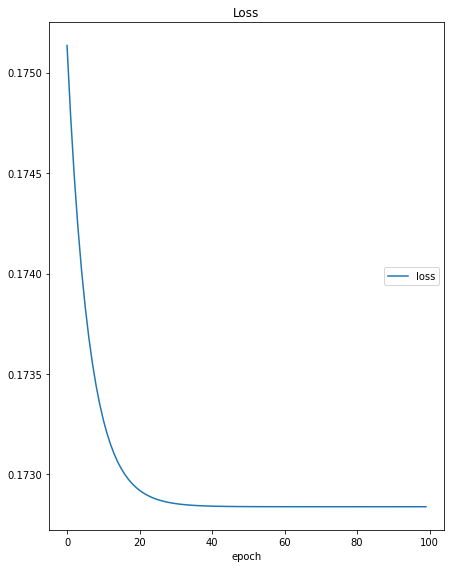

Loss
	loss             	 (min:    0.173, max:    0.175, cur:    0.173)
1/1 [==============================] - 0s 63ms/step


array([[0.22221208],
       [0.22221208],
       [0.22221208],
       [0.22221208],
       [0.22221208],
       [0.22221208],
       [0.22221208],
       [0.22221208],
       [0.22221208]], dtype=float32)

In [ ]:
adam.learning_rate = 0.1
nonlinear_model_10.compile(loss='mse', optimizer='sgd')
nonlinear_model_10.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_10.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

the method fails lets try classification instead

# Nonlinear generator attempt N2

In [ ]:
class NonlinearGenerator2(tf.keras.utils.Sequence):

  def __init__(self, batch_size):
    self.batch_size = batch_size

  def __len__(self):
    return 1#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x = []
    batch_y = []
    for i in range(self.batch_size):
      xi = np.random.randint(0, 9 ,1)[0]
      yi = 1 if xi in [2, 3] else 0
      batch_x.append(xi)
      batch_y.append(yi)    
    return np.array(batch_x), np.array(batch_y)

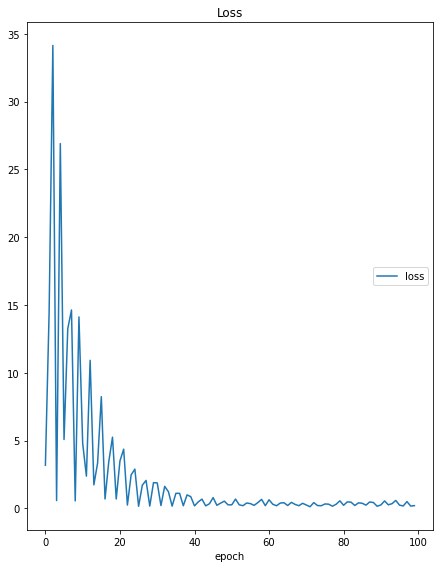

Loss
	loss             	 (min:    0.116, max:   34.143, cur:    0.197)
1/1 [==============================] - 0s 74ms/step


array([[0.5809126],
       [0.5809126],
       [0.5809126],
       [0.5809126],
       [0.5809126],
       [0.5809126],
       [0.5809126],
       [0.5809126],
       [0.5809126]], dtype=float32)

In [ ]:
nonlinear_model_10 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='tanh'),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_10.compile(loss='mse', optimizer=adam)
nonlinear_model_10.fit(NonlinearGenerator2(batch_size=32), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_10.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

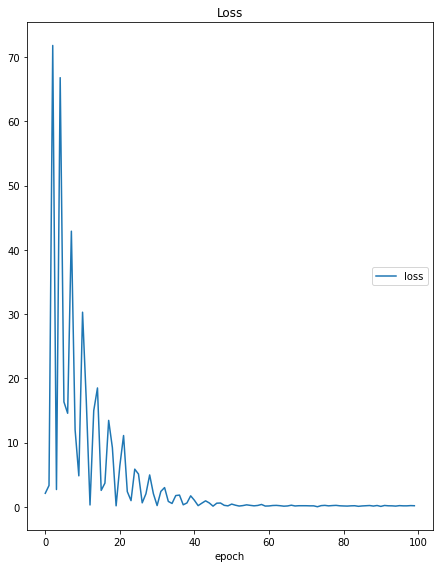

Loss
	loss             	 (min:    0.032, max:   71.785, cur:    0.188)
1/1 [==============================] - 0s 63ms/step


array([[0.27450848],
       [0.27450848],
       [0.27450848],
       [0.27450848],
       [0.27450848],
       [0.27450848],
       [0.27450848],
       [0.27450848],
       [0.27450848]], dtype=float32)

In [ ]:
nonlinear_model_10 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='tanh'),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_10.compile(loss='mse', optimizer=adam)
nonlinear_model_10.fit(NonlinearGenerator2(batch_size=32), batch_size=1, epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_10.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

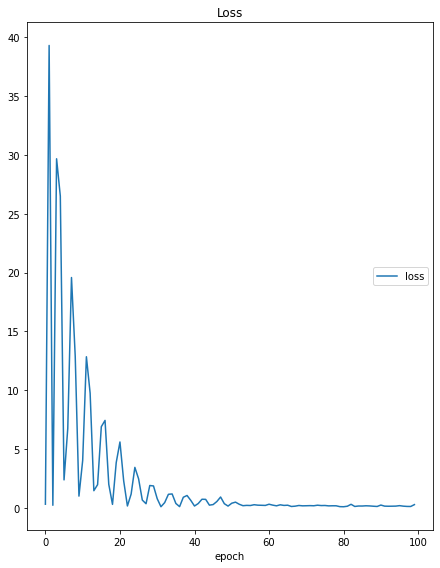

Loss
	loss             	 (min:    0.110, max:   39.298, cur:    0.290)
1/1 [==============================] - 0s 76ms/step


array([[0.14654483],
       [0.14654483],
       [0.14654483],
       [0.14654483],
       [0.14654483],
       [0.14654483],
       [0.14654483],
       [0.14654483],
       [0.14654481]], dtype=float32)

In [ ]:
nonlinear_model_11 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(8, input_shape=[1,], activation='tanh'),
     tf.keras.layers.Dense(2, activation='softmax'),
     tf.keras.layers.Dense(1)])
adam.learning_rate = 1
nonlinear_model_11.compile(loss='mse', optimizer=adam)
nonlinear_model_11.fit(NonlinearGenerator2(batch_size=32), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_11.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

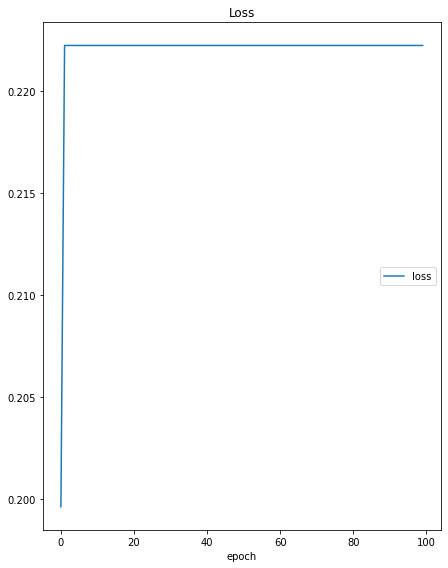

Loss
	loss             	 (min:    0.200, max:    0.222, cur:    0.222)
1/1 [==============================] - 0s 80ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
nonlinear_model_12 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(9, input_shape=[1,], activation='sigmoid'),
     tf.keras.layers.Dense(2, activation='sigmoid'),
     tf.keras.layers.Dense(1, activation='hard_sigmoid')])
adam.learning_rate = 1
nonlinear_model_12.compile(loss='mse', optimizer=adam)
nonlinear_model_12.fit(NonlinearGenerator(), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_12.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

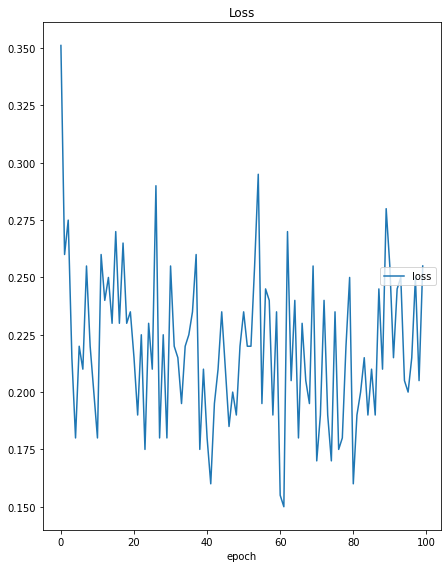

Loss
	loss             	 (min:    0.150, max:    0.351, cur:    0.255)
1/1 [==============================] - 0s 79ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
nonlinear_model_12 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(9, input_shape=[1,], activation='sigmoid'),
     tf.keras.layers.Dense(2, activation='sigmoid'),
     tf.keras.layers.Dense(1, activation='hard_sigmoid')])
adam.learning_rate = 1
nonlinear_model_12.compile(loss='mse', optimizer=adam)
nonlinear_model_12.fit(NonlinearGenerator2(batch_size=2000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_12.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

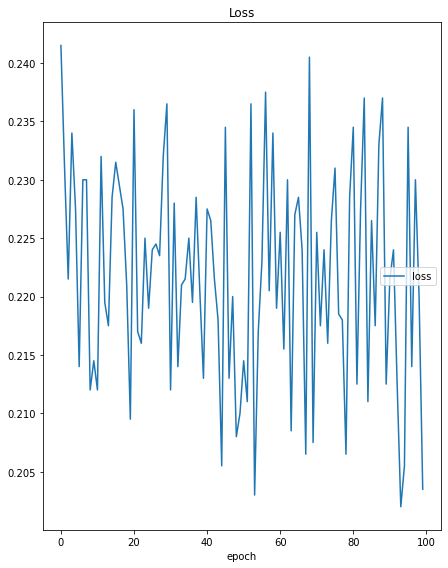

Loss
	loss             	 (min:    0.202, max:    0.242, cur:    0.204)
1/1 [==============================] - 0s 83ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
adam.learning_rate = 0.01
nonlinear_model_12.compile(loss='mse', optimizer=adam)
nonlinear_model_12.fit(NonlinearGenerator2(batch_size=2000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_12.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
nonlinear_model_12.get_weights()

[array([[ 31.924501, -31.306824, -32.208454, -31.993408,  31.11247 ,
         -31.814709, -31.264101, -31.405024, -31.087118]], dtype=float32),
 array([ 31.545494, -31.491674, -31.508295, -31.59507 ,  31.612951,
        -31.051886, -31.624172, -31.61781 , -31.340508], dtype=float32),
 array([[ 32.03415 , -31.699518],
        [ 32.149548, -31.402294],
        [ 32.00554 , -31.281097],
        [ 31.098251, -31.464731],
        [ 31.577478, -32.279522],
        [ 31.842514, -31.516514],
        [ 31.873413, -30.934834],
        [ 32.08672 , -31.137897],
        [ 31.995724, -31.47685 ]], dtype=float32),
 array([ 31.647545, -31.65419 ], dtype=float32),
 array([[-32.07721 ],
        [-30.340666]], dtype=float32),
 array([-31.656223], dtype=float32)]

# Nonlinear generator attempt N3


In [ ]:
class NonlinearGenerator3(tf.keras.utils.Sequence):

  def __init__(self, batch_size):
    self.batch_size = batch_size

  def __len__(self):
    return 1#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x = []
    batch_y = []
    for i in range(self.batch_size):
      xi = i % 9
      yi = 1 if xi in [2, 3] else 0
      yi = tf.keras.utils.to_categorical(yi, num_classes=2)
      batch_x.append(xi)
      batch_y.append(yi)    
    return np.array(batch_x), np.array(batch_y)

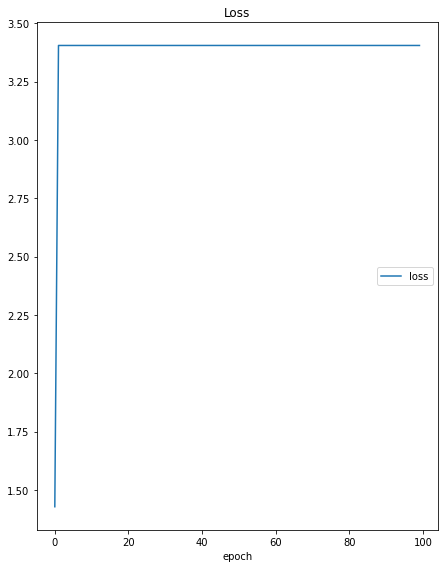

Loss
	loss             	 (min:    1.428, max:    3.405, cur:    3.405)
1/1 [==============================] - 0s 67ms/step


array([[ 66.2598  , -63.462685],
       [ 66.2598  , -63.462685],
       [ 66.2598  , -63.462685],
       [ 66.2598  , -63.462685],
       [ 66.2598  , -63.462685],
       [ 66.2598  , -63.462685],
       [ 66.2598  , -63.462685],
       [ 66.2598  , -63.462685],
       [ 66.2598  , -63.462685]], dtype=float32)

In [ ]:
nonlinear_model_13 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='tanh'),
    tf.keras.layers.Dense(2)])
adam.learning_rate = 1
nonlinear_model_13.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_model_13.fit(NonlinearGenerator3(batch_size=1000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_13.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

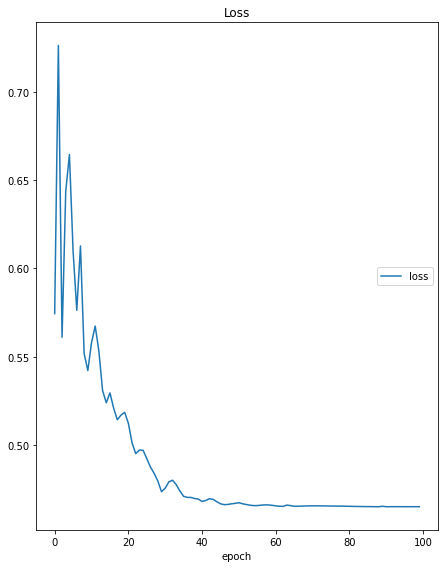

Loss
	loss             	 (min:    0.465, max:    0.726, cur:    0.465)
1/1 [==============================] - 0s 75ms/step


array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.7139347 , 0.28921676],
       [0.7130452 , 0.29001355],
       [0.7130438 , 0.29001474],
       [0.7130438 , 0.29001474],
       [0.7130438 , 0.29001474],
       [0.7130438 , 0.29001474],
       [0.7130438 , 0.29001474]], dtype=float32)

In [ ]:
nonlinear_model_14 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='tanh'),
    tf.keras.layers.Dense(2, activation='hard_sigmoid')])
adam.learning_rate = 0.1
nonlinear_model_14.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_model_14.fit(NonlinearGenerator3(batch_size=1000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_14.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

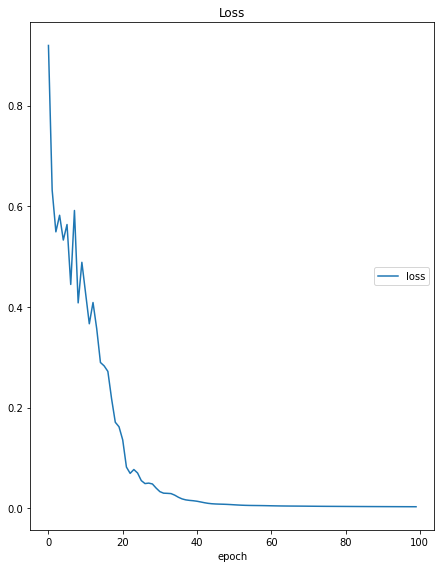

Loss
	loss             	 (min:    0.003, max:    0.920, cur:    0.003)
1/1 [==============================] - 0s 64ms/step


array([[9.9678516e-01, 2.9942465e-03],
       [9.9562889e-01, 4.0936065e-03],
       [2.8430654e-03, 9.9751115e-01],
       [9.6680708e-03, 9.9120373e-01],
       [9.9327826e-01, 5.6400974e-03],
       [9.9910694e-01, 7.0706470e-04],
       [9.9915934e-01, 6.6444860e-04],
       [9.9916059e-01, 6.6340389e-04],
       [9.9916065e-01, 6.6337670e-04]], dtype=float32)

In [ ]:
nonlinear_model_15 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='tanh'),
    tf.keras.layers.Dense(2, activation='sigmoid')])
adam.learning_rate = 0.1
nonlinear_model_15.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_model_15.fit(NonlinearGenerator3(batch_size=1000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_15.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
np.argmax(nonlinear_model_15.predict([0, 1, 2, 3, 4, 5, 6, 7, 8]), axis=1)

1/1 [==============================] - 0s 58ms/step


array([0, 0, 1, 1, 0, 0, 0, 0, 0])

First success!

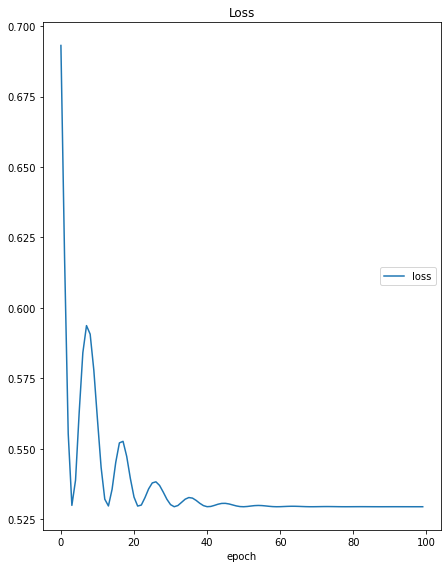

Loss
	loss             	 (min:    0.529, max:    0.693, cur:    0.529)
1/1 [==============================] - 0s 85ms/step


array([[0.77903754, 0.22096245],
       [0.77903754, 0.22096245],
       [0.77903754, 0.22096245],
       [0.77903754, 0.22096245],
       [0.77903754, 0.22096245],
       [0.77903754, 0.22096245],
       [0.77903754, 0.22096245],
       [0.77903754, 0.22096245],
       [0.77903754, 0.22096245]], dtype=float32)

In [ ]:
nonlinear_model_16 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')])
adam.learning_rate = 0.1
nonlinear_model_16.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_model_16.fit(NonlinearGenerator3(batch_size=1000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_16.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

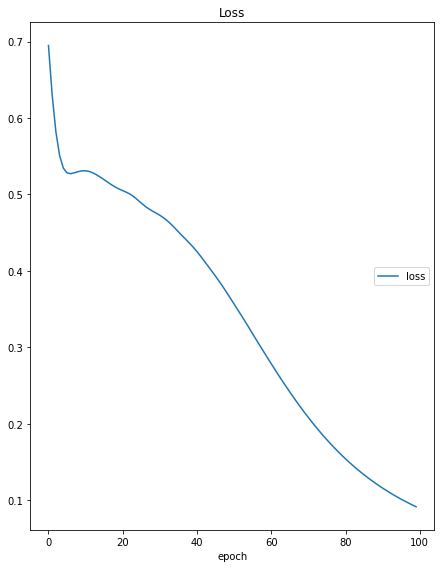

Loss
	loss             	 (min:    0.091, max:    0.695, cur:    0.091)
1/1 [==============================] - 0s 186ms/step


array([[0.9896074 , 0.00347295],
       [0.95875514, 0.02127572],
       [0.18474951, 0.89798135],
       [0.3228913 , 0.77358085],
       [0.8382357 , 0.14019471],
       [0.9535676 , 0.0273908 ],
       [0.9633813 , 0.02012174],
       [0.9644897 , 0.01933544],
       [0.9646232 , 0.01924124]], dtype=float32)

In [ ]:
nonlinear_model_17 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[1,], activation='sigmoid'),
    tf.keras.layers.Dense(2, activation='sigmoid')])
adam.learning_rate = 0.1
nonlinear_model_17.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_model_17.fit(NonlinearGenerator3(batch_size=1000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
nonlinear_model_17.predict([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
np.argmax(nonlinear_model_17.predict([0, 1, 2, 3, 4, 5, 6, 7, 8]), axis=1)

1/1 [==============================] - 0s 79ms/step


array([0, 0, 1, 1, 0, 0, 0, 0, 0])

Even better than tanh

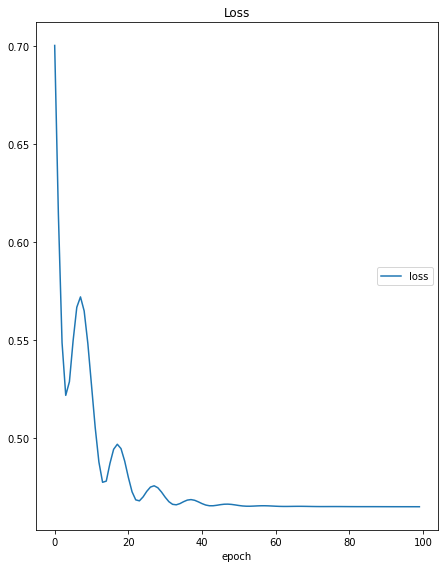

Loss
	loss             	 (min:    0.465, max:    0.700, cur:    0.465)
1/1 [==============================] - 0s 67ms/step
[[9.9985278e-01 1.1110771e-04]
 [9.9877036e-01 9.9897850e-04]
 [7.1333301e-01 2.8503615e-01]
 [7.1299207e-01 2.8538767e-01]
 [7.1299201e-01 2.8538767e-01]
 [7.1299201e-01 2.8538767e-01]
 [7.1299201e-01 2.8538767e-01]
 [7.1299201e-01 2.8538767e-01]
 [7.1299207e-01 2.8538767e-01]]

1/1 [==============================] - 0s 33ms/step
[0 0 0 0 0 0 0 0 0]


In [ ]:
nonlinear_model_18 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(1, input_shape=[1,], activation='sigmoid'),
    tf.keras.layers.Dense(2, activation='sigmoid')])
adam.learning_rate = 0.1
nonlinear_model_18.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_model_18.fit(NonlinearGenerator3(batch_size=1000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
print(nonlinear_model_18.predict([0, 1, 2, 3, 4, 5, 6, 7, 8]))
print()
print(np.argmax(nonlinear_model_18.predict([0, 1, 2, 3, 4, 5, 6, 7, 8]), axis=1))

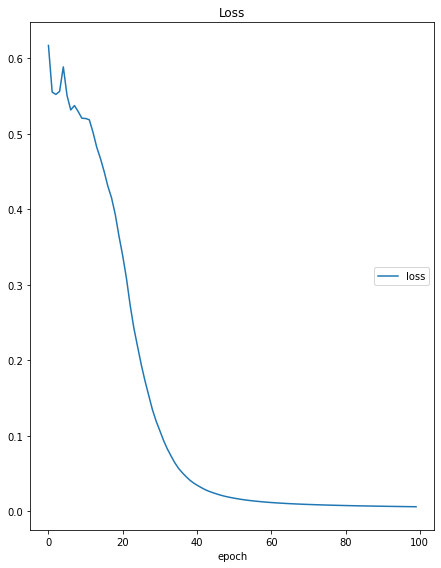

Loss
	loss             	 (min:    0.006, max:    0.617, cur:    0.006)
1/1 [==============================] - 0s 64ms/step
[[0.99882776 0.00463548]
 [0.9980938  0.00689191]
 [0.00680943 0.9857916 ]
 [0.01439269 0.97258705]
 [0.99308413 0.01101648]
 [0.998842   0.00230507]
 [0.99887747 0.00224311]
 [0.99887794 0.00224221]
 [0.99887794 0.00224219]]

1/1 [==============================] - 0s 32ms/step
[0 0 1 1 0 0 0 0 0]


In [ ]:
nonlinear_model_19 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(2, input_shape=[1,], activation='sigmoid'),
    tf.keras.layers.Dense(2, activation='sigmoid')])
adam.learning_rate = 0.1
nonlinear_model_19.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_model_19.fit(NonlinearGenerator3(batch_size=1000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
print(nonlinear_model_19.predict([0, 1, 2, 3, 4, 5, 6, 7, 8]))
print()
print(np.argmax(nonlinear_model_19.predict([0, 1, 2, 3, 4, 5, 6, 7, 8]), axis=1))

Not as good as sigmoid x3, but still works

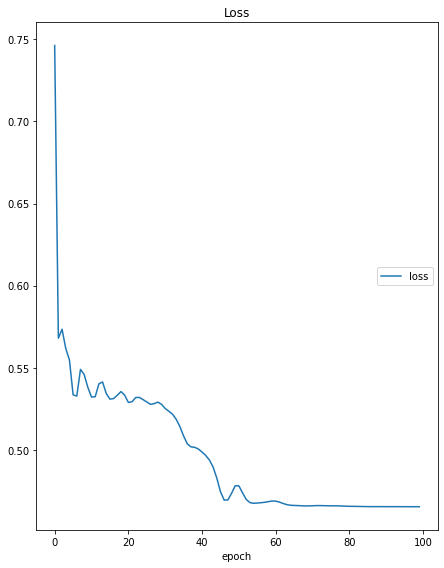

Loss
	loss             	 (min:    0.465, max:    0.746, cur:    0.465)
1/1 [==============================] - 0s 67ms/step
[[9.9937576e-01 4.0593545e-04]
 [9.9659932e-01 2.4723434e-03]
 [7.1486944e-01 2.8332454e-01]
 [7.1442980e-01 2.8379112e-01]
 [7.1442980e-01 2.8379112e-01]
 [7.1442980e-01 2.8379112e-01]
 [7.1442980e-01 2.8379112e-01]
 [7.1442980e-01 2.8379112e-01]
 [7.1442980e-01 2.8379112e-01]]

1/1 [==============================] - 0s 35ms/step
[0 0 0 0 0 0 0 0 0]


In [ ]:
nonlinear_model_20 = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(2, input_shape=[1,], activation='tanh'),
    tf.keras.layers.Dense(2, activation='sigmoid')])
adam.learning_rate = 0.1
nonlinear_model_20.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_model_20.fit(NonlinearGenerator3(batch_size=1000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
print(nonlinear_model_20.predict([0, 1, 2, 3, 4, 5, 6, 7, 8]))
print()
print(np.argmax(nonlinear_model_20.predict([0, 1, 2, 3, 4, 5, 6, 7, 8]), axis=1))

# Nonlinear single factor Categorical

In [ ]:
class NonlinearGenerator3cat(tf.keras.utils.Sequence):

  def __init__(self, batch_size):
    self.batch_size = batch_size

  def __len__(self):
    return 1#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x = []
    batch_y = []
    for i in range(self.batch_size):
      xi = i % 9
      yi = 1 if xi in [2, 3] else 0
      xi = tf.keras.utils.to_categorical(xi, num_classes=9)
      yi = tf.keras.utils.to_categorical(yi, num_classes=2)
      batch_x.append(xi)
      batch_y.append(yi)    
    return np.array(batch_x), np.array(batch_y)

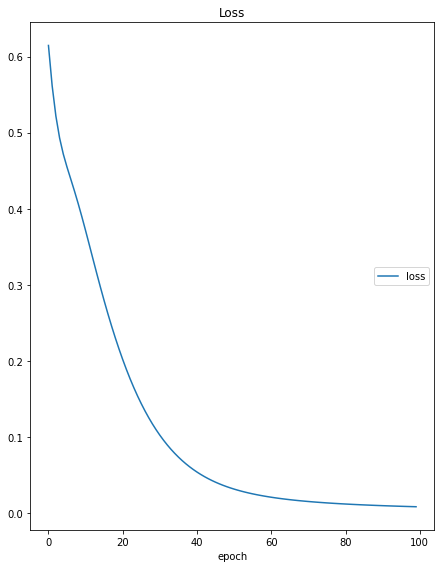

Loss
	loss             	 (min:    0.009, max:    0.615, cur:    0.009)
1/1 [==============================] - 0s 98ms/step


array([[0.9988913 , 0.00261931],
       [0.99879867, 0.00287107],
       [0.01763004, 0.95471007],
       [0.01808251, 0.9539786 ],
       [0.9988185 , 0.00274605],
       [0.9989375 , 0.00258108],
       [0.99892735, 0.00257607],
       [0.99879384, 0.00280345],
       [0.99892247, 0.00262309]], dtype=float32)

In [ ]:
adam = tf.keras.optimizers.Adam()
nonlinear_model_17cat = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(3, input_shape=[9,], activation='sigmoid'),
    tf.keras.layers.Dense(2, activation='sigmoid')])
adam.learning_rate = 0.1
nonlinear_model_17cat.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_model_17cat.fit(
    NonlinearGenerator3cat(batch_size=9),
    epochs=100,
    verbose=False,
    callbacks=[PlotLossesKeras()]
    )
nonlinear_model_17cat.predict(tf.keras.utils.to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8]))

# Nonlinear two-factor

In [ ]:
class NonlinearTwoFactorGenerator(tf.keras.utils.Sequence):

  def __init__(self, batch_size):
    self.batch_size = batch_size

  def __len__(self):
    return 1#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x = []
    batch_y = []
    for i in range(self.batch_size):
      x0i = (i // 9) % 2
      x1i = i % 9
      if x0i:
        yi = 1 if x1i in [2, 3] else 0
      else:
        yi = 1 if x1i == 3 else 0
      yi = tf.keras.utils.to_categorical(yi, num_classes=2)
      batch_x.append([x0i, x1i])
      batch_y.append(yi)    
    return np.array(batch_x), np.array(batch_y)

## Decision Tree (Easily deals with the task)

In [ ]:
import sklearn

[Text(0.6, 0.9, 'X[1] <= 3.5\ngini = 0.278\nsamples = 18\nvalue = [[3, 15]\n[15, 3]]'),
 Text(0.4, 0.7, 'X[1] <= 1.5\ngini = 0.469\nsamples = 8\nvalue = [[3, 5]\n[5, 3]]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [[0, 4]\n[4, 0]]'),
 Text(0.6, 0.5, 'X[0] <= 0.5\ngini = 0.375\nsamples = 4\nvalue = [[3, 1]\n[1, 3]]'),
 Text(0.4, 0.3, 'X[1] <= 2.5\ngini = 0.5\nsamples = 2\nvalue = [[1, 1]\n[1, 1]]'),
 Text(0.2, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [[0, 1]\n[1, 0]]'),
 Text(0.6, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [[1, 0]\n[0, 1]]'),
 Text(0.8, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [[2, 0]\n[0, 2]]'),
 Text(0.8, 0.7, 'gini = 0.0\nsamples = 10\nvalue = [[0, 10]\n[10, 0]]')]

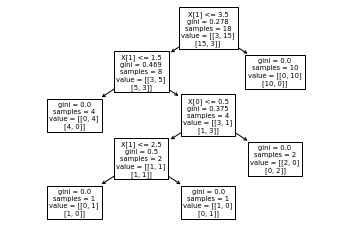

In [ ]:
dtree = sklearn.tree.DecisionTreeClassifier()
x, y = NonlinearTwoFactorGenerator(18).__getitem__(0)
dtree.fit(x, y)
sklearn.tree.plot_tree(dtree)

In [ ]:
pred = dtree.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(np.argmax(pred, axis=1))

[0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0]


In [ ]:
pred = dtree.predict(
    np.array([
        [1, 100], [0, -5]
        ])
    )
print(np.argmax(pred, axis=1))

[0 0]


Perfect results in no time

## Let NN try

### Failing architecture anyway

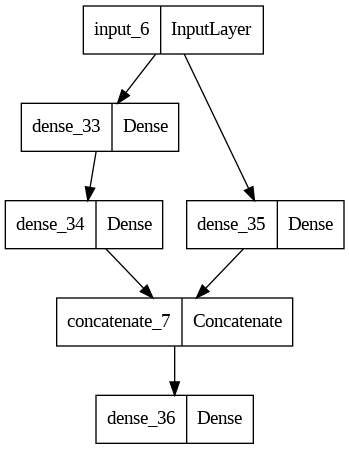

In [ ]:
input_layer = tf.keras.layers.Input(shape=[2,])
l1 = tf.keras.layers.Dense(2, activation='sigmoid')(input_layer)
l2 = tf.keras.layers.Dense(2, activation='sigmoid')(l1)
l3 = tf.keras.layers.Dense(1, activation='sigmoid')(input_layer)
concat_layer = tf.keras.layers.Concatenate()([l2, l3])
output_layer = tf.keras.layers.Dense(2, activation='sigmoid')(concat_layer)
nonlinear_twofactor_model = tf.keras.models.Model(
    inputs=input_layer,
    outputs=output_layer)
tf.keras.utils.plot_model(nonlinear_twofactor_model)

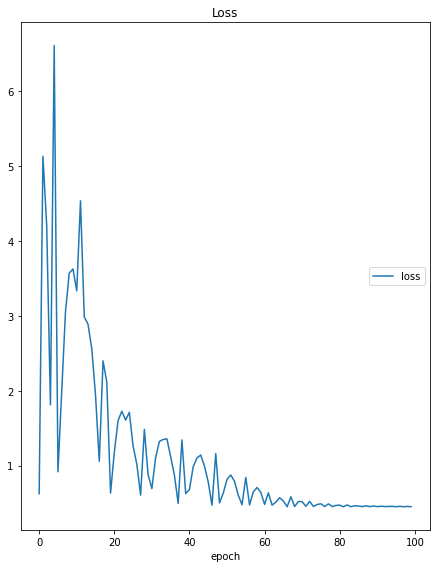

Loss
	loss             	 (min:    0.450, max:    6.615, cur:    0.450)
1/1 [==============================] - 0s 48ms/step
[[0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]
 [0.7923321  0.16022804]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 10
nonlinear_twofactor_model.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_twofactor_model.fit(NonlinearTwoFactorGenerator(batch_size=1000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
pred = nonlinear_twofactor_model.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(pred)
print()
print(np.argmax(pred, axis=1))

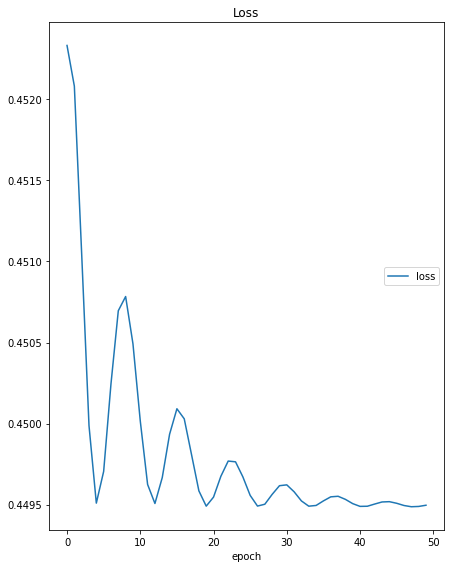

Loss
	loss             	 (min:    0.449, max:    0.452, cur:    0.449)
1/1 [==============================] - 0s 55ms/step
[[0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]
 [0.8368964  0.16641898]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
adam.learning_rate = 1
nonlinear_twofactor_model.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_twofactor_model.fit(NonlinearTwoFactorGenerator(batch_size=1000), epochs=50, verbose=False, callbacks=[PlotLossesKeras()])
pred = nonlinear_twofactor_model.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(pred)
print()
print(np.argmax(pred, axis=1))

### More promissing one

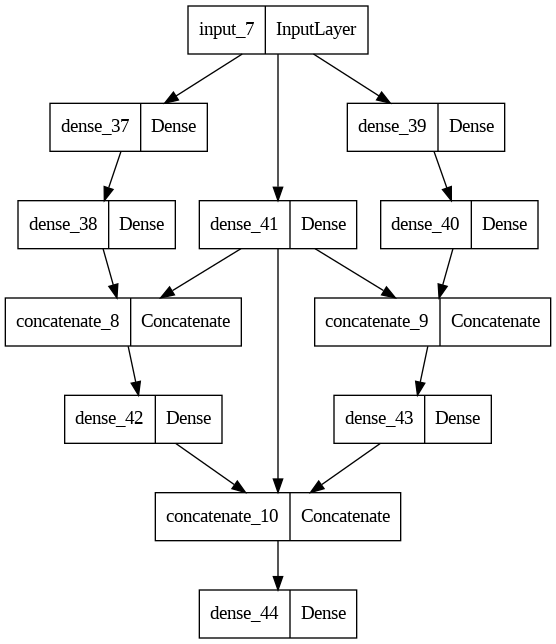

In [ ]:
input_layer = tf.keras.layers.Input(shape=[2,])
l10 = tf.keras.layers.Dense(2, activation='sigmoid')(input_layer)
l20 = tf.keras.layers.Dense(2, activation='sigmoid')(l10)
l11 = tf.keras.layers.Dense(2, activation='sigmoid')(input_layer)
l21 = tf.keras.layers.Dense(2, activation='sigmoid')(l11)
l3 = tf.keras.layers.Dense(1, activation='sigmoid')(input_layer)
concat_layer_0 = tf.keras.layers.Concatenate()([l20, l3])
concat_layer_1 = tf.keras.layers.Concatenate()([l21, l3])
l40 = tf.keras.layers.Dense(1, activation='sigmoid')(concat_layer_0)
l41 = tf.keras.layers.Dense(1, activation='sigmoid')(concat_layer_1)
concat_layer = tf.keras.layers.Concatenate()([l40 , l41, l3])
output_layer = tf.keras.layers.Dense(2, activation='sigmoid')(concat_layer)
nonlinear_twofactor_model_2 = tf.keras.models.Model(
    inputs=input_layer,
    outputs=output_layer)
tf.keras.utils.plot_model(nonlinear_twofactor_model_2)

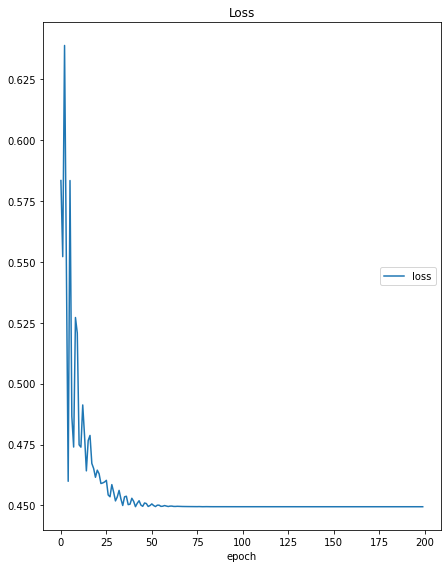

Loss
	loss             	 (min:    0.449, max:    0.639, cur:    0.449)
1/1 [==============================] - 0s 75ms/step
[[0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
adam.learning_rate = 1
nonlinear_twofactor_model_2.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_twofactor_model_2.fit(NonlinearTwoFactorGenerator(batch_size=1000), epochs=200, verbose=False, callbacks=[PlotLossesKeras()])
pred = nonlinear_twofactor_model_2.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(pred)
print()
print(np.argmax(pred, axis=1))

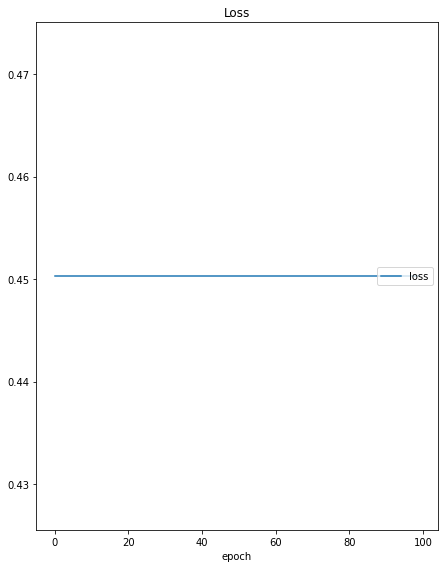

Loss
	loss             	 (min:    0.450, max:    0.450, cur:    0.450)
1/1 [==============================] - 0s 82ms/step
[[0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]
 [0.834003   0.16599414]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
adam.learning_rate = 0.1
nonlinear_twofactor_model_2.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_twofactor_model_2.fit(NonlinearTwoFactorGenerator(batch_size=2000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
pred = nonlinear_twofactor_model_2.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(pred)
print()
print(np.argmax(pred, axis=1))

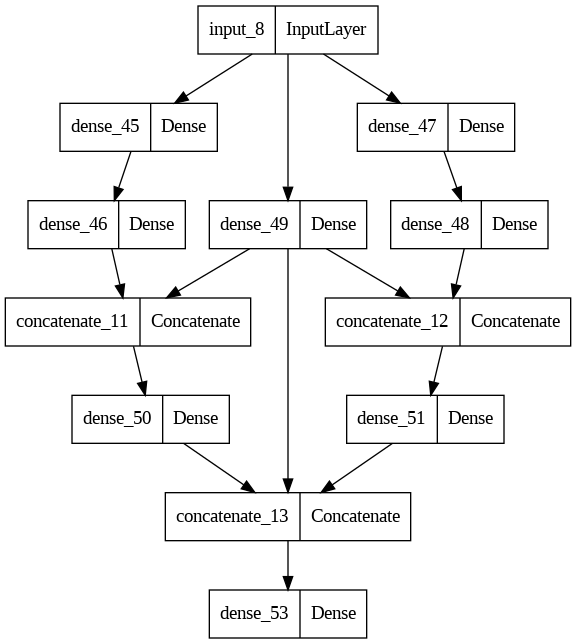

In [ ]:
input_layer = tf.keras.layers.Input(shape=[2,])
l10 = tf.keras.layers.Dense(2, activation='sigmoid')(input_layer)
l20 = tf.keras.layers.Dense(2, activation='sigmoid')(l10)
l11 = tf.keras.layers.Dense(2, activation='sigmoid')(input_layer)
l21 = tf.keras.layers.Dense(2, activation='sigmoid')(l11)
l3 = tf.keras.layers.Dense(1, activation='sigmoid')(input_layer)
concat_layer_0 = tf.keras.layers.Concatenate()([l20, l3])
concat_layer_1 = tf.keras.layers.Concatenate()([l21, l3])
l40 = tf.keras.layers.Dense(1, activation='sigmoid')(concat_layer_0)
l41 = tf.keras.layers.Dense(1, activation='sigmoid')(concat_layer_1)
concat_layer = tf.keras.layers.Concatenate()([l40 , l41, l3])
one_layer = tf.keras.layers.Dense(400, activation='sigmoid')(concat_layer)
output_layer = tf.keras.layers.Dense(2, activation='sigmoid')(concat_layer)
nonlinear_twofactor_model_2b = tf.keras.models.Model(
    inputs=input_layer,
    outputs=output_layer)
tf.keras.utils.plot_model(nonlinear_twofactor_model_2b)

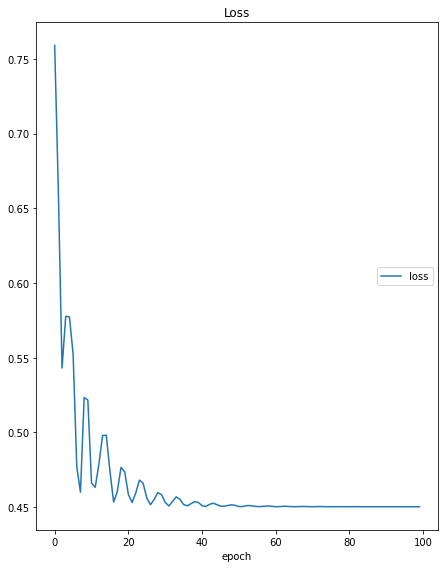

Loss
	loss             	 (min:    0.450, max:    0.759, cur:    0.450)
1/1 [==============================] - 0s 72ms/step
[[0.83487445 0.16703564]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
adam.learning_rate = 1
nonlinear_twofactor_model_2b.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_twofactor_model_2b.fit(NonlinearTwoFactorGenerator(batch_size=2000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
pred = nonlinear_twofactor_model_2b.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(pred)
print()
print(np.argmax(pred, axis=1))

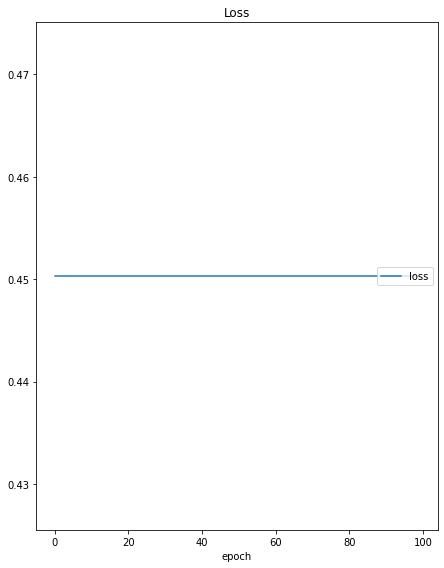

Loss
	loss             	 (min:    0.450, max:    0.450, cur:    0.450)
1/1 [==============================] - 0s 73ms/step
[[0.83487445 0.16703564]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]
 [0.83487207 0.16703673]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
adam.learning_rate = 0.01
nonlinear_twofactor_model_2b.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_twofactor_model_2b.fit(NonlinearTwoFactorGenerator(batch_size=2000), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
pred = nonlinear_twofactor_model_2b.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(pred)
print()
print(np.argmax(pred, axis=1))

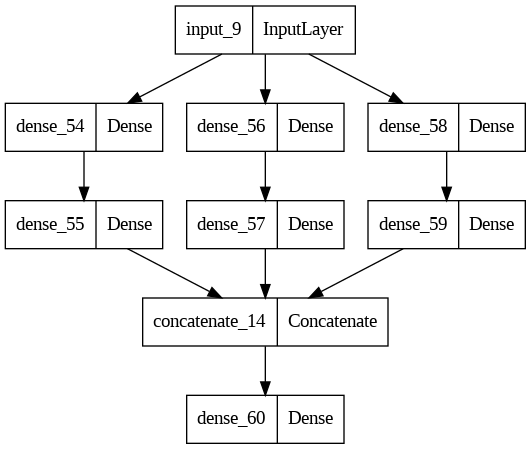

In [ ]:
input_layer_m3 = tf.keras.layers.Input(shape=[2,])
l10_m3 = tf.keras.layers.Dense(3, activation='sigmoid')(input_layer_m3)
l20_m3 = tf.keras.layers.Dense(2, activation='sigmoid')(l10_m3)
l11_m3 = tf.keras.layers.Dense(3, activation='sigmoid')(input_layer_m3)
l21_m3 = tf.keras.layers.Dense(2, activation='sigmoid')(l11_m3)
lc0_m3 = tf.keras.layers.Dense(1)(input_layer_m3)
lc1_m3 = tf.keras.layers.Dense(1, activation='tanh')(lc0_m3)
concat_layer_m3 = tf.keras.layers.Concatenate()([l20_m3, l21_m3, lc1_m3])
output_layer_m3 = tf.keras.layers.Dense(2, activation='sigmoid')(concat_layer_m3)
nonlinear_twofactor_model_3 = tf.keras.models.Model(
    inputs=input_layer_m3,
    outputs=output_layer_m3)
tf.keras.utils.plot_model(nonlinear_twofactor_model_3)

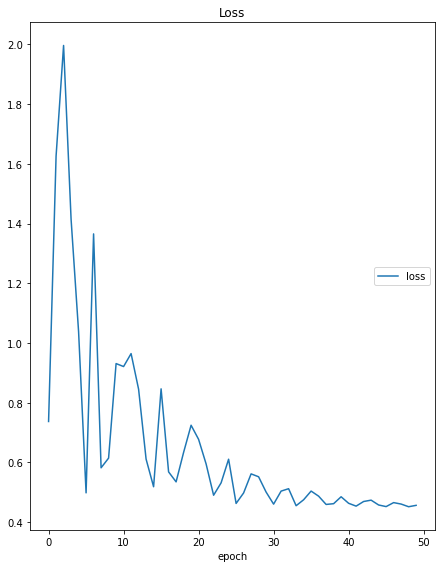

Loss
	loss             	 (min:    0.452, max:    1.997, cur:    0.456)
1/1 [==============================] - 0s 63ms/step
[[0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
adam.learning_rate = 1
nonlinear_twofactor_model_3.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_twofactor_model_3.fit(NonlinearTwoFactorGenerator(batch_size=2000), epochs=50, verbose=False, callbacks=[PlotLossesKeras()])
pred = nonlinear_twofactor_model_3.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(pred)
print()
print(np.argmax(pred, axis=1))

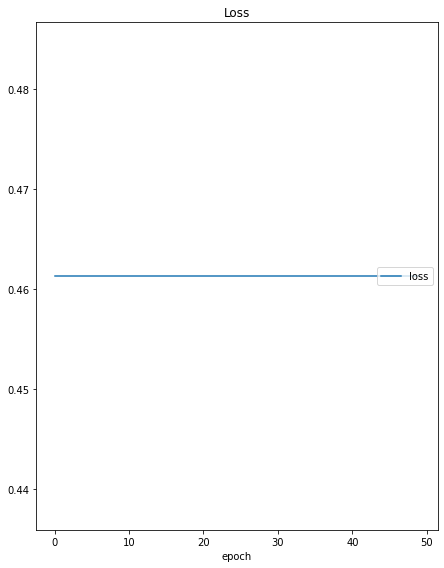

Loss
	loss             	 (min:    0.461, max:    0.461, cur:    0.461)
1/1 [==============================] - 0s 62ms/step
[[0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]
 [0.90026206 0.1822766 ]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
adam.learning_rate = 0.01
nonlinear_twofactor_model_3.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_twofactor_model_3.fit(NonlinearTwoFactorGenerator(batch_size=2000), epochs=50, verbose=False, callbacks=[PlotLossesKeras()])
pred = nonlinear_twofactor_model_3.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(pred)
print()
print(np.argmax(pred, axis=1))

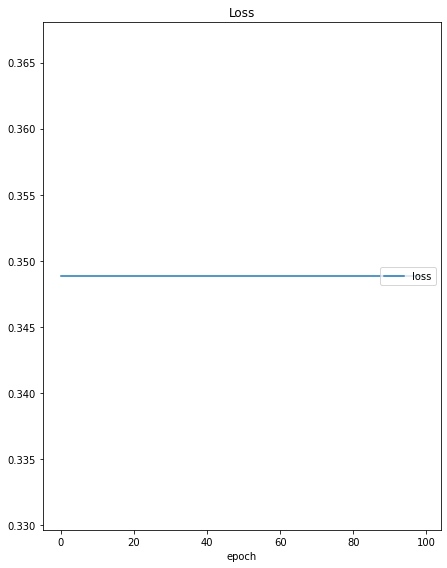

Loss
	loss             	 (min:    0.349, max:    0.349, cur:    0.349)
1/1 [==============================] - 0s 59ms/step
[[0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]
 [0.8915989  0.11085559]]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
adam.learning_rate = 0.01
nonlinear_twofactor_model_3.compile(loss='binary_crossentropy', optimizer=adam)
nonlinear_twofactor_model_3.fit(NonlinearTwoFactorGenerator(batch_size=18), epochs=100, verbose=False, callbacks=[PlotLossesKeras()])
pred = nonlinear_twofactor_model_3.predict(
    np.array([
        [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8],
        [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]
        ])
    )
print(pred)
print()
print(np.argmax(pred, axis=1))

# Nonlinear two-factor attempt 2 (Split inputs)

In [62]:
class NonlinearTwoFactorGenerator2(tf.keras.utils.Sequence):

  def __init__(self, batch_size):
    self.batch_size = batch_size

  def __len__(self):
    return 18#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x0 = []
    batch_x1 = []
    batch_y = []
    for i in range(self.batch_size):
      x0i = (i // 9) % 2
      x1i = i % 9
      if x0i:
        yi = 1 if x1i in [2, 3] else 0
      else:
        yi = 1 if x1i == 3 else 0
      #yi = tf.keras.utils.to_categorical(yi, num_classes=2)
      batch_x0.append(x0i)
      batch_x1.append(x1i)
      batch_y.append(yi)    
    return [np.array(batch_x0), np.array(batch_x1)], np.array(batch_y)

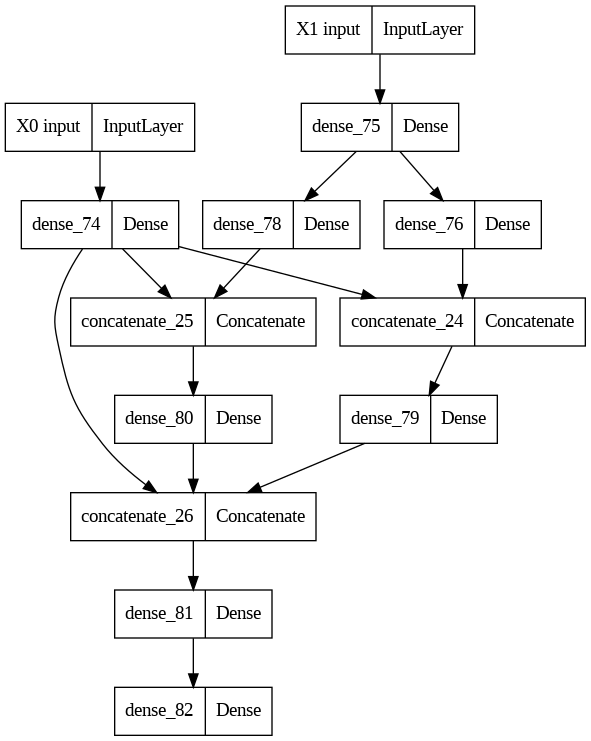

In [ ]:
nl2f_m5_input_layer_x0 = tf.keras.layers.Input(shape=[1,], name='X0 input')
nl2f_m5_layer_d01 = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m5_input_layer_x0)

nl2f_m5_input_layer_x1 = tf.keras.layers.Input(shape=[1,], name='X1 input')
nl2f_m5_layer_d11a = tf.keras.layers.Dense(3, activation='sigmoid')(nl2f_m5_input_layer_x1)
nl2f_m5_layer_d12a = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m5_layer_d11a)
nl2f_m5_layer_d11b = tf.keras.layers.Dense(3, activation='sigmoid')(nl2f_m5_input_layer_x1)
nl2f_m5_layer_d12b = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m5_layer_d11a)

nl2f_m5_concat_layer_a = tf.keras.layers.Concatenate()([nl2f_m5_layer_d12a, nl2f_m5_layer_d01])
nl2f_m5_layer_d13a = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m5_concat_layer_a)
nl2f_m5_concat_layer_b = tf.keras.layers.Concatenate()([nl2f_m5_layer_d12b, nl2f_m5_layer_d01])
nl2f_m5_layer_d13b = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m5_concat_layer_b)

nl2f_m5_concat_layer = tf.keras.layers.Concatenate()(
  [
    nl2f_m5_layer_d01,
    nl2f_m5_layer_d13a,
    nl2f_m5_layer_d13b
  ]
)

nl2f_m5_layer_d = tf.keras.layers.Dense(18, activation='sigmoid')(nl2f_m5_concat_layer)
nl2f_m5_output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m5_layer_d)

nl2f_m5 = tf.keras.models.Model(
    inputs=[nl2f_m5_input_layer_x0, nl2f_m5_input_layer_x1],
    outputs=nl2f_m5_output_layer
    )
tf.keras.utils.plot_model(nl2f_m5)

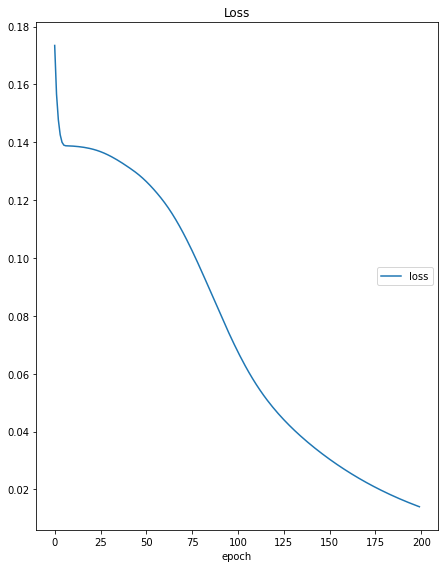

Loss
	loss             	 (min:    0.014, max:    0.173, cur:    0.014)
18/18 [==============================] - 0s 18ms/step - loss: 0.0140


In [ ]:
nl2f_m5.compile(loss='mse')
nl2f_m5.fit(NonlinearTwoFactorGenerator2(18), epochs=200, callbacks=[PlotLossesKeras()])

In [ ]:
pred = nl2f_m5.predict(
    [np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1]),
    np.array([0,1,2,3,4,5,6,7,8,0,1,2,3,4,5,6,7,8])]
)
print(pred)
print()
# print(np.argmax(pred, axis=1))
np.round(pred).flatten().astype(int)

1/1 [==============================] - 0s 106ms/step
[[9.3175600e-05]
 [4.0092054e-04]
 [2.9619429e-01]
 [7.3503321e-01]
 [2.7223192e-02]
 [1.9654739e-04]
 [1.1047738e-05]
 [2.7699634e-06]
 [1.4535856e-06]
 [9.1608940e-04]
 [4.0745470e-03]
 [7.9905152e-01]
 [9.5992202e-01]
 [2.2219288e-01]
 [1.9673449e-03]
 [9.9568206e-05]
 [2.3128843e-05]
 [1.1647560e-05]]



array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

# Nonlinear Split Inputs Categorical

In [61]:
class Nl2SplitInputCategoricalGenerator(tf.keras.utils.Sequence):
  """Nonlinear Two-Factor SplitInput Categorical Generator"""

  def __init__(self, batch_size):
    self.batch_size = batch_size

  def __len__(self):
    return 1#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x0 = []
    batch_x1 = []
    batch_y = []
    for i in range(self.batch_size):
      x0i = (i // 9) % 2
      x1i = i % 9
      if x0i:
        yi = 1 if x1i in [2, 3] else 0
      else:
        yi = 1 if x1i == 3 else 0
      x0i = tf.keras.utils.to_categorical(x0i, num_classes=2)
      x1i = tf.keras.utils.to_categorical(x1i, num_classes=9)
      yi = tf.keras.utils.to_categorical(yi, num_classes=2)
      batch_x0.append(x0i)
      batch_x1.append(x1i)
      batch_y.append(yi)    
    return [np.array(batch_x0), np.array(batch_x1)], np.array(batch_y)

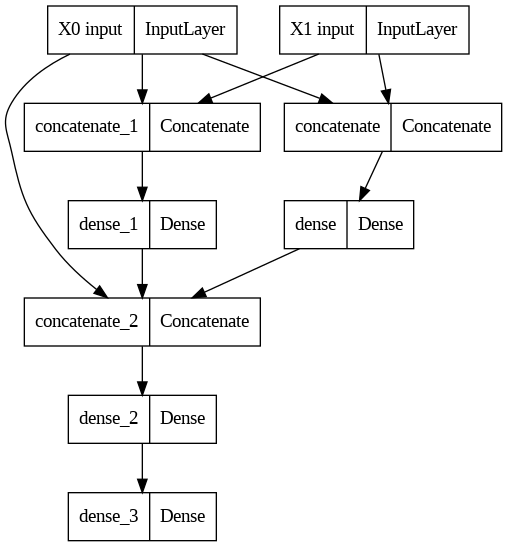

In [17]:
nl2f_m6_input_layer_x0 = tf.keras.layers.Input(shape=[2,], name='X0 input')

nl2f_m6_input_layer_x1 = tf.keras.layers.Input(shape=[9,], name='X1 input')

nl2f_m6_concat_layer_a = tf.keras.layers.Concatenate()([nl2f_m6_input_layer_x1, nl2f_m6_input_layer_x0])
nl2f_m6_layer_d13a = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m6_concat_layer_a)
nl2f_m6_concat_layer_b = tf.keras.layers.Concatenate()([nl2f_m6_input_layer_x1, nl2f_m6_input_layer_x0])
nl2f_m6_layer_d13b = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m6_concat_layer_b)

nl2f_m6_concat_layer = tf.keras.layers.Concatenate()(
  [
    nl2f_m6_input_layer_x0,
    nl2f_m6_layer_d13a,
    nl2f_m6_layer_d13b
  ]
)

nl2f_m6_layer_d = tf.keras.layers.Dense(18, activation='sigmoid')(nl2f_m6_concat_layer)
nl2f_m6_output_layer = tf.keras.layers.Dense(2, activation='sigmoid')(nl2f_m6_layer_d)

nl2f_m6 = tf.keras.models.Model(
    inputs=[nl2f_m6_input_layer_x0, nl2f_m6_input_layer_x1],
    outputs=nl2f_m6_output_layer
    )
tf.keras.utils.plot_model(nl2f_m6)

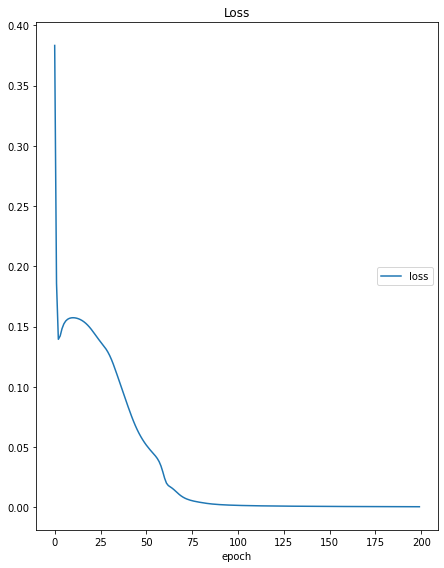

Loss
	loss             	 (min:    0.000, max:    0.383, cur:    0.000)
1/1 [==============================] - 0s 229ms/step - loss: 4.4937e-04


In [18]:
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 0.1
nl2f_m6.compile(loss='mse', optimizer=adam)
nl2f_m6.fit(
    Nl2SplitInputCategoricalGenerator(18),
    epochs=200,
    callbacks=[PlotLossesKeras()])

In [19]:
pred = nl2f_m6.predict(
    Nl2SplitInputCategoricalGenerator(18).__getitem__(0)[0]
)
print(pred)
print()
print(np.argmax(pred, axis=1))

1/1 [==============================] - 0s 71ms/step
[[0.9969108  0.00380696]
 [0.9969121  0.00380546]
 [0.9926497  0.00861569]
 [0.04906823 0.94607496]
 [0.996911   0.0038068 ]
 [0.9969121  0.00380546]
 [0.9969108  0.00380696]
 [0.9969115  0.00380617]
 [0.99691164 0.00380605]
 [0.9927591  0.00836827]
 [0.992836   0.008288  ]
 [0.04716518 0.94816375]
 [0.04586077 0.94955283]
 [0.9924158  0.00875778]
 [0.99271774 0.00842204]
 [0.9925961  0.00855281]
 [0.9927648  0.00836546]
 [0.9925939  0.00855964]]

[0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0]


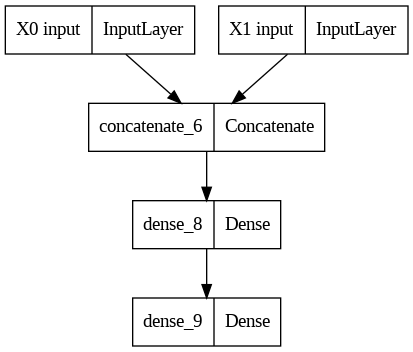

In [21]:
nl2f_m7_input_layer_x0 = tf.keras.layers.Input(shape=[2,], name='X0 input')
nl2f_m7_input_layer_x1 = tf.keras.layers.Input(shape=[9,], name='X1 input')

nl2f_m7_concat_layer = tf.keras.layers.Concatenate()(
  [
    nl2f_m7_input_layer_x0,
    nl2f_m7_input_layer_x1
  ]
)

nl2f_m7_layer_d = tf.keras.layers.Dense(18, activation='sigmoid')(nl2f_m7_concat_layer)
nl2f_m7_output_layer = tf.keras.layers.Dense(2, activation='sigmoid')(nl2f_m7_layer_d)

nl2f_m7 = tf.keras.models.Model(
    inputs=[nl2f_m7_input_layer_x0, nl2f_m7_input_layer_x1],
    outputs=nl2f_m7_output_layer
    )
tf.keras.utils.plot_model(nl2f_m7)

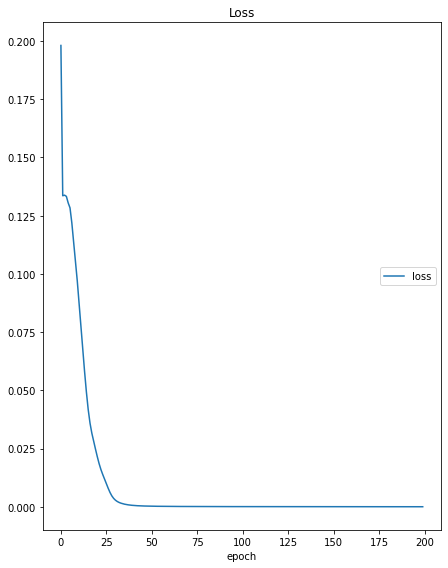

Loss
	loss             	 (min:    0.000, max:    0.198, cur:    0.000)
1/1 [==============================] - 0s 237ms/step - loss: 4.3497e-05


In [23]:
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 0.1
nl2f_m7.compile(loss='mse', optimizer=adam)
nl2f_m7.fit(
    Nl2SplitInputCategoricalGenerator(18),
    epochs=200,
    callbacks=[PlotLossesKeras()])

In [24]:
pred = nl2f_m7.predict(
    Nl2SplitInputCategoricalGenerator(18).__getitem__(0)[0]
)
print(pred)
print()
print(np.argmax(pred, axis=1))

1/1 [==============================] - 0s 34ms/step
[[9.9999607e-01 8.7381515e-05]
 [9.9999636e-01 8.5261578e-05]
 [9.9587458e-01 1.7122570e-02]
 [2.9308479e-03 9.7995442e-01]
 [9.9999607e-01 8.9088753e-05]
 [9.9999613e-01 8.9659159e-05]
 [9.9999595e-01 9.2248200e-05]
 [9.9999613e-01 9.0921269e-05]
 [9.9999654e-01 8.3425999e-05]
 [9.9850750e-01 5.9103793e-03]
 [9.9861145e-01 5.7246825e-03]
 [3.8671384e-03 9.7661906e-01]
 [2.7435290e-04 9.9615389e-01]
 [9.9861610e-01 5.7870490e-03]
 [9.9849707e-01 6.1566406e-03]
 [9.9863976e-01 5.8571752e-03]
 [9.9854678e-01 6.2005194e-03]
 [9.9866742e-01 5.7495651e-03]]

[0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0]


nl2f_m7 is the best so far (simplicity vs epochs before trained)

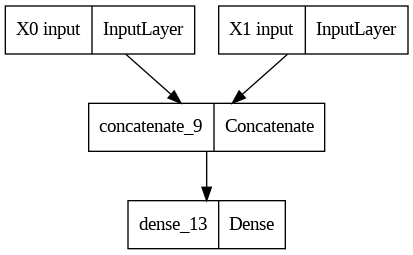

In [28]:
nl2f_m8_input_layer_x0 = tf.keras.layers.Input(shape=[2,], name='X0 input')
nl2f_m8_input_layer_x1 = tf.keras.layers.Input(shape=[9,], name='X1 input')

nl2f_m8_concat_layer = tf.keras.layers.Concatenate()(
  [
    nl2f_m8_input_layer_x0,
    nl2f_m8_input_layer_x1
  ]
)
nl2f_m8_output_layer = tf.keras.layers.Dense(2, activation='sigmoid')(nl2f_m8_concat_layer)

nl2f_m8 = tf.keras.models.Model(
    inputs=[nl2f_m8_input_layer_x0, nl2f_m8_input_layer_x1],
    outputs=nl2f_m8_output_layer
    )
tf.keras.utils.plot_model(nl2f_m8)

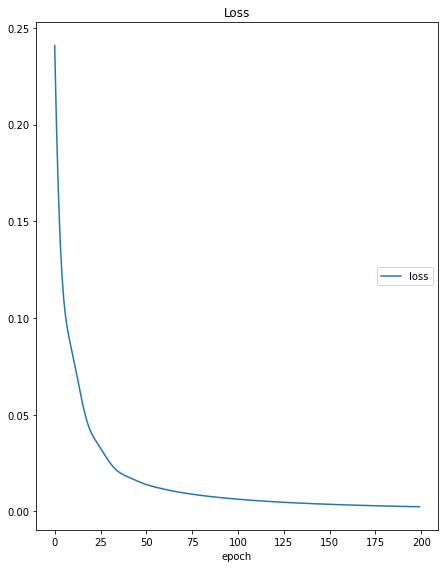

Loss
	loss             	 (min:    0.002, max:    0.241, cur:    0.002)
1/1 [==============================] - 0s 200ms/step - loss: 0.0025


In [26]:
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 0.1
nl2f_m8.compile(loss='mse', optimizer=adam)
nl2f_m8.fit(
    Nl2SplitInputCategoricalGenerator(18),
    epochs=200,
    callbacks=[PlotLossesKeras()])

In [27]:
pred = nl2f_m8.predict(
    Nl2SplitInputCategoricalGenerator(18).__getitem__(0)[0]
)
print(pred)
print()
print(np.argmax(pred, axis=1))

1/1 [==============================] - 0s 213ms/step
[[9.9930954e-01 4.0872287e-04]
 [9.9923325e-01 7.0925022e-04]
 [8.8723892e-01 1.0913081e-01]
 [9.2820361e-02 9.0517396e-01]
 [9.9946553e-01 5.6619861e-04]
 [9.9923718e-01 7.4334542e-04]
 [9.9945122e-01 4.2317965e-04]
 [9.9928045e-01 6.8899232e-04]
 [9.9944305e-01 4.6419067e-04]
 [9.6035123e-01 2.5972962e-02]
 [9.5616025e-01 4.4238560e-02]
 [1.1635750e-01 8.8874954e-01]
 [1.7093981e-03 9.9839616e-01]
 [9.6903425e-01 3.5628922e-02]
 [9.5637476e-01 4.6268329e-02]
 [9.6823138e-01 2.6867323e-02]
 [9.5874768e-01 4.3028541e-02]
 [9.6777517e-01 2.9395733e-02]]

[0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0]


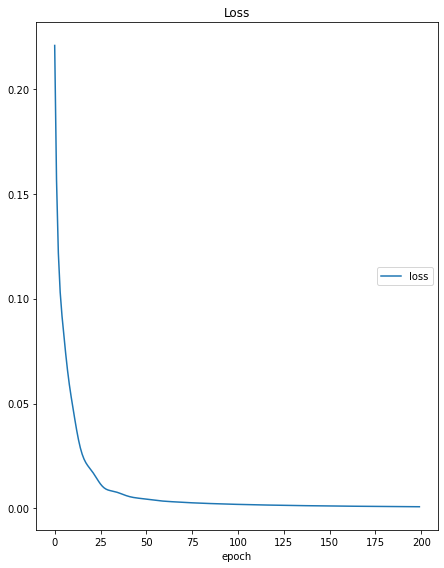

Loss
	loss             	 (min:    0.001, max:    0.221, cur:    0.001)
1/1 [==============================] - 0s 218ms/step - loss: 7.6477e-04


In [29]:
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 0.2
nl2f_m8.compile(loss='mse', optimizer=adam)
nl2f_m8.fit(
    Nl2SplitInputCategoricalGenerator(18),
    epochs=200,
    callbacks=[PlotLossesKeras()])

nl2f_m8 can not be simpler, but still works

# Nonlinear Split Inputs Integers (Attempt 2, simplified models)

let's test nl2f_m8 (mdoified in the inputs part) on the integer (non-categorical) input

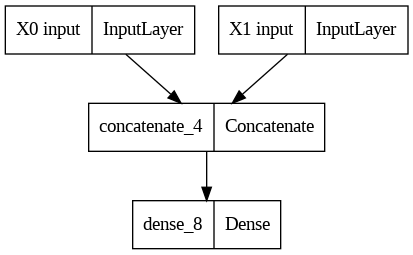

In [72]:
nl2f_m9_input_layer_x0 = tf.keras.layers.Input(shape=[1,], name='X0 input')
nl2f_m9_input_layer_x1 = tf.keras.layers.Input(shape=[1,], name='X1 input')

nl2f_m9_concat_layer = tf.keras.layers.Concatenate()(
  [
    nl2f_m9_input_layer_x0,
    nl2f_m9_input_layer_x1
  ]
)
nl2f_m9_output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m9_concat_layer)

nl2f_m9 = tf.keras.models.Model(
    inputs=[nl2f_m9_input_layer_x0, nl2f_m9_input_layer_x1],
    outputs=nl2f_m9_output_layer
    )
tf.keras.utils.plot_model(nl2f_m9)

In [73]:
NonlinearTwoFactorGenerator2(18).__getitem__(0)

([array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])],
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]))

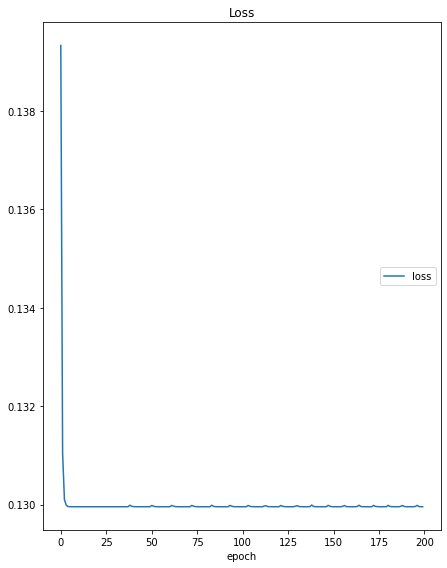

Loss
	loss             	 (min:    0.130, max:    0.139, cur:    0.130)
18/18 [==============================] - 0s 16ms/step - loss: 0.1300


In [74]:
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 0.1
nl2f_m9.compile(loss='mse', optimizer=adam)
nl2f_m9.fit(
    NonlinearTwoFactorGenerator2(18),
    epochs=200,
    callbacks=[PlotLossesKeras()])

In [86]:
pred = nl2f_m9.predict(
   NonlinearTwoFactorGenerator2(18).__getitem__(0)[0]
)
pred.astype(int).flatten()

1/1 [==============================] - 0s 48ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

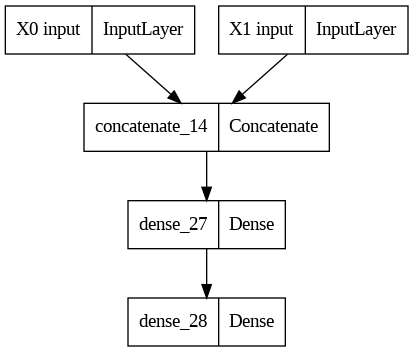

In [153]:
nl2f_m10_input_layer_x0 = tf.keras.layers.Input(shape=[1,], name='X0 input')
nl2f_m10_input_layer_x1 = tf.keras.layers.Input(shape=[1,], name='X1 input')

nl2f_m10_concat_layer = tf.keras.layers.Concatenate()(
  [
    nl2f_m10_input_layer_x0,
    nl2f_m10_input_layer_x1
  ]
)
nl2f_m10_d_layer = tf.keras.layers.Dense(18, activation='sigmoid')(nl2f_m10_concat_layer)
nl2f_m10_output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m10_d_layer)

nl2f_m10 = tf.keras.models.Model(
    inputs=[nl2f_m10_input_layer_x0, nl2f_m10_input_layer_x1],
    outputs=nl2f_m10_output_layer
    )
tf.keras.utils.plot_model(nl2f_m10)

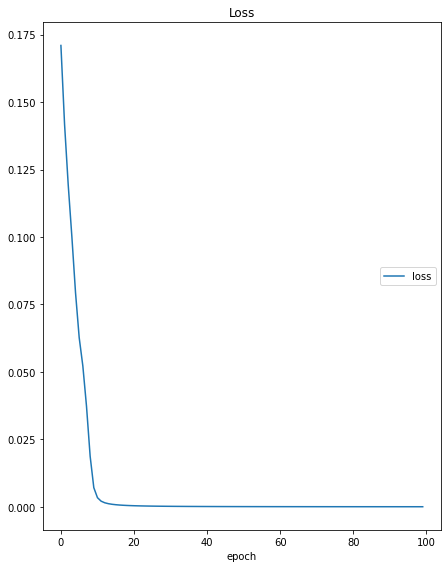

Loss
	loss             	 (min:    0.000, max:    0.171, cur:    0.000)
18/18 [==============================] - 0s 16ms/step - loss: 1.8057e-05


In [154]:
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 0.1
nl2f_m10.compile(loss='mse', optimizer=adam)
nl2f_m10.fit(
    NonlinearTwoFactorGenerator2(18),
    epochs=100,
    callbacks=[PlotLossesKeras()])

In [132]:
NonlinearTwoFactorGenerator2(18).__getitem__(0)

([array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])],
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]))

In [155]:
np.round(nl2f_m10\
.predict(
    [
    np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 
    np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8]),     
    ]
    )).flatten().astype(int)

1/1 [==============================] - 0s 72ms/step


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [156]:
nl2f_m10.get_weights()

[array([[-1.3195636 , -1.0003967 ,  0.6031155 , -2.742881  , -0.9725112 ,
          0.8991536 , -5.928458  , -2.6821542 ,  2.5617623 , -3.2645686 ,
         -8.434335  , -0.7653898 , -1.1481723 ,  0.98671323,  1.862346  ,
         -0.85736483, -1.1896926 , -1.9489182 ],
        [-0.93428254, -0.99259824, -1.4750991 , -5.784826  , -4.3768153 ,
         -1.6439474 ,  2.747051  , -1.5962528 , -1.9661531 ,  1.9846159 ,
          3.603215  , -0.9627592 , -1.3590117 , -2.0271947 , -2.8317318 ,
         -1.3466498 , -4.2843776 , -5.2506833 ]], dtype=float32),
 array([-1.0014943 , -0.7666795 , -0.02847462, 12.922275  ,  9.13493   ,
         0.74666715, -2.0519419 , -0.77719265,  1.5464877 , -2.242437  ,
        -2.8443763 , -0.8831839 , -0.66606766,  2.0892997 ,  3.725366  ,
        -0.55270845, 15.140699  , 11.492385  ], dtype=float32),
 array([[-0.11518724],
        [-0.07942098],
        [-0.7789064 ],
        [-5.0314546 ],
        [-4.1178184 ],
        [-0.707746  ],
        [-2.7867515 

nl2f_m10: Integers redeemed!

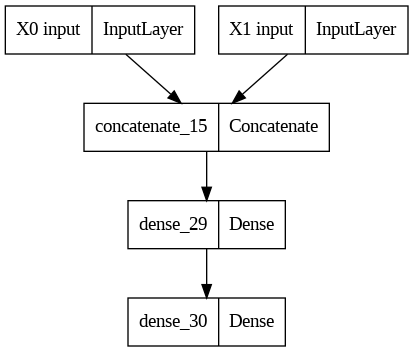

In [157]:
nl2f_m11_input_layer_x0 = tf.keras.layers.Input(shape=[1,], name='X0 input')
nl2f_m11_input_layer_x1 = tf.keras.layers.Input(shape=[1,], name='X1 input')

nl2f_m11_concat_layer = tf.keras.layers.Concatenate()(
  [
    nl2f_m11_input_layer_x0,
    nl2f_m11_input_layer_x1
  ]
)
nl2f_m11_d_layer = tf.keras.layers.Dense(9, activation='sigmoid')(nl2f_m11_concat_layer)
nl2f_m11_output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m11_d_layer)

nl2f_m11 = tf.keras.models.Model(
    inputs=[nl2f_m11_input_layer_x0, nl2f_m11_input_layer_x1],
    outputs=nl2f_m11_output_layer
    )
tf.keras.utils.plot_model(nl2f_m11)

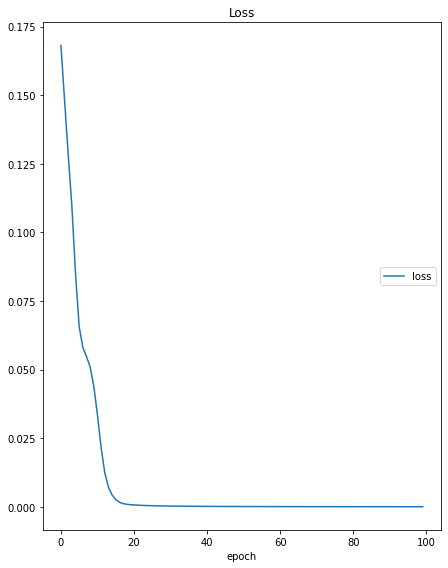

Loss
	loss             	 (min:    0.000, max:    0.168, cur:    0.000)
18/18 [==============================] - 0s 16ms/step - loss: 2.6019e-05


In [158]:
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 0.1
nl2f_m11.compile(loss='mse', optimizer=adam)
nl2f_m11.fit(
    NonlinearTwoFactorGenerator2(18),
    epochs=100,
    callbacks=[PlotLossesKeras()])

In [159]:
pred = nl2f_m11.predict(
   NonlinearTwoFactorGenerator2(18).__getitem__(0)[0]
)
np.round(pred).astype(int).flatten()

1/1 [==============================] - 0s 52ms/step


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [160]:
np.round(nl2f_m10\
.predict(
    [
    np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 
    np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8]),     
    ]
    )).flatten().astype(int)

1/1 [==============================] - 0s 21ms/step


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

nl2f_m11: still good lets simplify further!

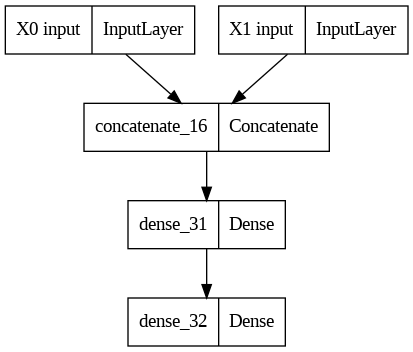

In [161]:
nl2f_m12_input_layer_x0 = tf.keras.layers.Input(shape=[1,], name='X0 input')
nl2f_m12_input_layer_x1 = tf.keras.layers.Input(shape=[1,], name='X1 input')

nl2f_m12_concat_layer = tf.keras.layers.Concatenate()(
  [
    nl2f_m12_input_layer_x0,
    nl2f_m12_input_layer_x1
  ]
)
nl2f_m12_d_layer = tf.keras.layers.Dense(3, activation='sigmoid')(nl2f_m12_concat_layer)
nl2f_m12_output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m12_d_layer)

nl2f_m12 = tf.keras.models.Model(
    inputs=[nl2f_m12_input_layer_x0, nl2f_m12_input_layer_x1],
    outputs=nl2f_m12_output_layer
    )
tf.keras.utils.plot_model(nl2f_m12)

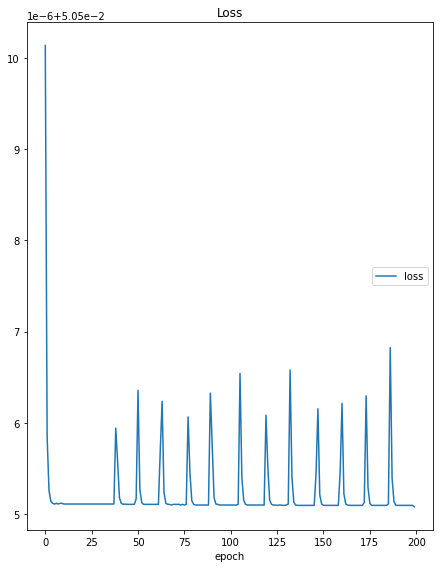

Loss
	loss             	 (min:    0.051, max:    0.051, cur:    0.051)
1/1 [==============================] - 0s 60ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [174]:
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 0.1
nl2f_m12.compile(loss='mse', optimizer=adam)
nl2f_m12.fit(
    NonlinearTwoFactorGenerator2(18),
    epochs=200,
    callbacks=[PlotLossesKeras()])
pred = nl2f_m12.predict(
   NonlinearTwoFactorGenerator2(18).__getitem__(0)[0]
)
np.round(pred).astype(int).flatten()

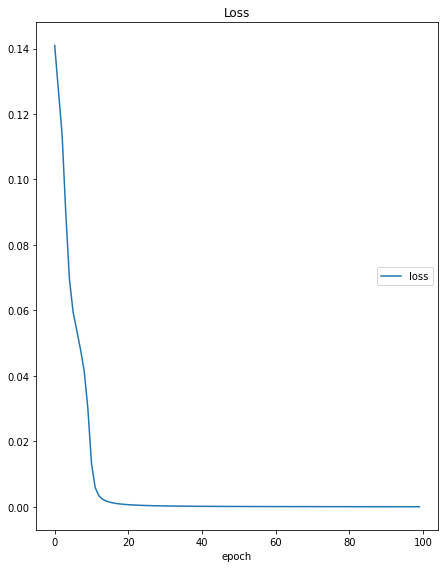

Loss
	loss             	 (min:    0.000, max:    0.141, cur:    0.000)
1/1 [==============================] - 0s 56ms/step


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [170]:
nl2f_m13_input_layer_x0 = tf.keras.layers.Input(shape=[1,], name='X0 input')
nl2f_m13_input_layer_x1 = tf.keras.layers.Input(shape=[1,], name='X1 input')

nl2f_m13_concat_layer = tf.keras.layers.Concatenate()(
  [
    nl2f_m13_input_layer_x0,
    nl2f_m13_input_layer_x1
  ]
)
nl2f_m13_d_layer = tf.keras.layers.Dense(4, activation='sigmoid')(nl2f_m13_concat_layer)
nl2f_m13_output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(nl2f_m13_d_layer)

nl2f_m13 = tf.keras.models.Model(
    inputs=[nl2f_m13_input_layer_x0, nl2f_m13_input_layer_x1],
    outputs=nl2f_m13_output_layer
    )
adam = tf.keras.optimizers.Adam()
adam.learning_rate = 0.1
nl2f_m13.compile(loss='mse', optimizer=adam)
nl2f_m13.fit(
    NonlinearTwoFactorGenerator2(18),
    epochs=100,
    callbacks=[PlotLossesKeras()])
pred = nl2f_m13.predict(
   NonlinearTwoFactorGenerator2(18).__getitem__(0)[0]
)
np.round(pred).astype(int).flatten()

2i - concat - dense 3 - out was capable once when it suddenly broke through.
<br><br>
But nl2f_m13 (2i - concat - dense 3 - out) is a stable and yet simple model for 2 integer inputs.
<br><br>
Also it is the best performing of all yet.

# Coral Dog Paper Sword

## Concept and weights

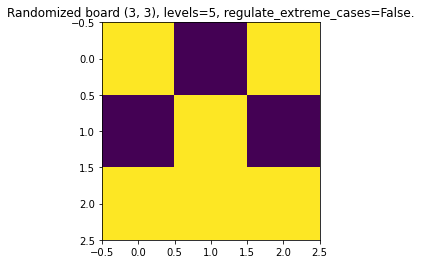

In [184]:
X = generate_board((3,3), show=True)

In [185]:
X

,0,1,2
0,1,0,1
1,0,1,0
2,1,1,1


In [186]:
c2d_layer = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=2)
c2d_layer(np.array(X)[None, ..., None].astype(float))
c2d_layer.get_weights()

[array([[[[ 0.25872782, -0.10072884]],
 
         [[ 0.20096877,  0.21470413]],
 
         [[ 0.31589523, -0.092922  ]]],
 
 
        [[[-0.1558651 ,  0.16767916]],
 
         [[ 0.45269254,  0.31218025]],
 
         [[ 0.30043814, -0.3885428 ]]],
 
 
        [[[-0.14363444, -0.39335653]],
 
         [[ 0.4112487 , -0.21057701]],
 
         [[-0.24992137,  0.45460942]]]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [187]:
c2d_weights = np.array([
    np.array([
    [ [[0, 1]], [[0, 1]], [[0, 1]] ],
    [ [[0, 1]], [[1, 0]], [[0, 1]] ],
    [ [[0, 1]], [[0, 1]], [[0, 1]] ]
    ]),
    np.array([0., 0.])
    ],
    dtype=object
)
c2d_layer.set_weights(c2d_weights)

In [188]:
c2d_layer(np.array(X)[None, ..., None].astype(float))

<tf.Tensor: shape=(1, 1, 1, 2), dtype=float32, numpy=array([[[[1., 5.]]]], dtype=float32)>

## Workout

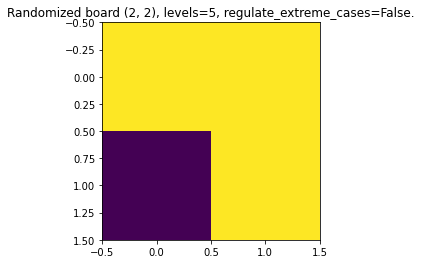

In [307]:
board_shape = (2,2)
X = generate_board(board_shape, padding=None, show=True)

In [308]:
def predict_board(int_model, board: pd.DataFrame, pad=0, show=True):
  """
  pad: None, 0, 1
  """
  X = board.copy()
  X = np.array(X)
  if pad is not None:
    X = np.pad(X, 1, mode='constant', constant_values=pad)
  c2d_output = c2d_layer(X[None, ..., None].astype(float))
  x0 = c2d_output[:, :, :, 0].numpy().flatten()
  x1 = c2d_output[:, :, :, 1].numpy().flatten()
  pred_output_tensor = int_model([x0, x1])
  pred_output = pred_output_tensor.numpy().reshape(board.shape)
  if show:
    plt.imshow(
        pd.DataFrame(pred_output).round().astype(int))
    plt.show()

In [298]:
X

,0,1
0,1,1
1,1,0


In [299]:
np.pad(X, 1)#, mode='constant', constant_values=0)

array([[0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0]])

ValueError: ignored

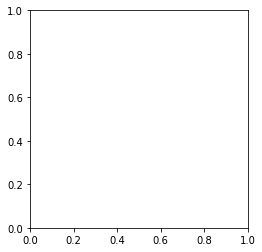

In [317]:
c2d_output = c2d_layer(np.pad(X, 1, mode='constant', constant_values=0)[None, ..., None].astype(float))
x0 = c2d_output[:, :, :, 0].numpy().flatten()
x1 = c2d_output[:, :, :, 1].numpy().flatten()
pred_output_tensor = nl2f_m13([x0, x1])
pred_output = pred_output_tensor.numpy().reshape(2,2)
plt.imshow(
        pd.DataFrame(pred_output).round().astype(int), cmap='yellow'
        )
plt.show()

In [314]:
pd.DataFrame(pred_output).round().astype(int)

,0,1
0,1,1
1,1,1


array([[0.9951738, 0.9951738],
       [0.9951738, 0.9846907]], dtype=float32)

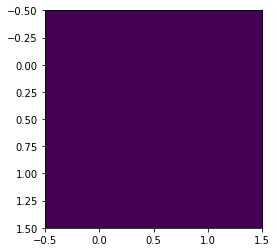

In [311]:
predict_board(nl2f_m13, X)

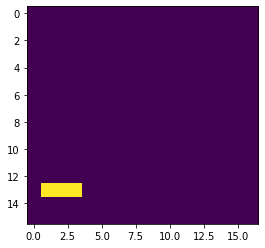

In [275]:
predict_board(nl2f_m13, board)

# Standalone

In [1]:
!pip install livelossplot --quiet

In [62]:
from livelossplot import PlotLossesKeras
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
import time

SHEET_ID = '1OdllC9j05ka_adHvipTn58XPqmLt5f1VLBzHFd9aRJQ'
SHEET_NAME = 'GoL'
SLEEP = 1.5

class NonlinearTwoFactorGenerator2(tf.keras.utils.Sequence):

  def __init__(self, batch_size):
    self.batch_size = batch_size

  def __len__(self):
    return 1#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x0 = []
    batch_x1 = []
    batch_y = []
    for i in range(self.batch_size):
      x0i = (i // 9) % 2
      x1i = i % 9
      if x0i:
        yi = 1 if x1i in [2, 3] else 0
      else:
        yi = 1 if x1i == 3 else 0        
      batch_x0.append(x0i)
      batch_x1.append(x1i)
      batch_y.append(yi)    
    return [np.array(batch_x0), np.array(batch_x1)], np.array(batch_y)


class Nl2SplitInputCategoricalGenerator(tf.keras.utils.Sequence):
  """Nonlinear Two-Factor SplitInput Categorical Generator"""

  def __init__(self, batch_size):
    self.batch_size = batch_size

  def __len__(self):
    return 1#np.ceil(self.limit / self.batch_size).astype(int)

  def __getitem__(self, idx):
    batch_x0 = []
    batch_x1 = []
    batch_y = []
    for i in range(self.batch_size):
      x0i = (i // 9) % 2
      x1i = i % 9
      if x0i:
        yi = 1 if x1i in [2, 3] else 0
      else:
        yi = 1 if x1i == 3 else 0
      x0i = tf.keras.utils.to_categorical(x0i, num_classes=2)
      x1i = tf.keras.utils.to_categorical(x1i, num_classes=9)
      yi = tf.keras.utils.to_categorical(yi, num_classes=2)
      batch_x0.append(x0i)
      batch_x1.append(x1i)
      batch_y.append(yi)    
    return [np.array(batch_x0), np.array(batch_x1)], np.array(batch_y)


def get_integer_split_input_model(
    check=False, verbose=False, plot_losses=False):
  nl2f_m13_input_layer_x0 = tf.keras.layers.Input(shape=[1,], name='X0 input')
  nl2f_m13_input_layer_x1 = tf.keras.layers.Input(shape=[1,], name='X1 input')

  nl2f_m13_concat_layer = tf.keras.layers.Concatenate()(
    [
      nl2f_m13_input_layer_x0,
      nl2f_m13_input_layer_x1
    ]
  )
  nl2f_m13_d_layer = tf.keras.layers\
  .Dense(
      4,
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0),
      bias_initializer=tf.keras.initializers.GlorotUniform(seed=0)
      )(nl2f_m13_concat_layer)
  nl2f_m13_output_layer = tf.keras.layers\
  .Dense(
      1,
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0),
      bias_initializer=tf.keras.initializers.GlorotUniform(seed=0)
      )(nl2f_m13_d_layer)

  nl2f_m13 = tf.keras.models.Model(
      inputs=[nl2f_m13_input_layer_x0, nl2f_m13_input_layer_x1],
      outputs=nl2f_m13_output_layer
      )
  adam = tf.keras.optimizers.Adam()
  adam.learning_rate = 0.1
  nl2f_m13.compile(loss='mse', optimizer=adam)
  if plot_losses:
    callbacks = [PlotLossesKeras()]
  else:
    callbacks = []
  nl2f_m13.fit(
      NonlinearTwoFactorGenerator2(18),
      epochs=100,
      verbose=verbose,
      callbacks=callbacks
      )
  if check:
    test_set = NonlinearTwoFactorGenerator2(18).__getitem__(0)[0]
    pred = nl2f_m13.predict(test_set) 
    pred_format = np.round(pred).astype(int).flatten()
    print('Test Set:')
    print(test_set)
    print('Prediction:')
    print(pred_format)
    if ''.join(pred_format.astype(str)) == '000100000001100000':
      print('Model successfully trained.')
    else:
      print('Bad model.')
  return nl2f_m13


def get_categorical_split_input_model(
    check=False, verbose=False, plot_losses=False):
  
  nl2f_m8_input_layer_x0 = tf.keras.layers.Input(shape=[2,], name='X0 input')
  nl2f_m8_input_layer_x1 = tf.keras.layers.Input(shape=[9,], name='X1 input')

  nl2f_m8_concat_layer = tf.keras.layers.Concatenate()(
    [
      nl2f_m8_input_layer_x0,
      nl2f_m8_input_layer_x1
    ]
  )
  nl2f_m8_output_layer = tf.keras.layers\
  .Dense(2, activation='sigmoid')(nl2f_m8_concat_layer)

  nl2f_m8 = tf.keras.models.Model(
      inputs=[nl2f_m8_input_layer_x0, nl2f_m8_input_layer_x1],
      outputs=nl2f_m8_output_layer
      )
  if plot_losses:
    callbacks = [PlotLossesKeras()]
  else:
    callbacks = []
  adam = tf.keras.optimizers.Adam()
  adam.learning_rate = 0.2
  nl2f_m8.compile(loss='mse', optimizer=adam)
  nl2f_m8.fit(
      Nl2SplitInputCategoricalGenerator(18),
      epochs=100,
      verbose=verbose,
      callbacks=callbacks
      )
  if check:
    test_set = Nl2SplitInputCategoricalGenerator(18).__getitem__(0)[0]
    pred = nl2f_m8.predict(test_set)
    pred_format = np.argmax(pred, axis=1)
    print('Test Set:')
    print(test_set)
    print('Prediction:')
    print(pred_format)
    if ''.join(pred_format.astype(str)) == '000100000001100000':
      print('Model successfully trained.')
    else:
      print('Bad model.')
  return nl2f_m8


def generate_board(
    shape,
    padding=False,
    pad_value=1,
    levels=5,
    regulate_extreme_cases=False,
    show=False
    ):
  """
  'outer' padding surrounds the array with zeros (or pad_value, e.g. 1)
  the shape of the board changes (+2 to each dimension)
  padding at conv2d layer is meant to be set to 'valid'
  """
  if levels:
    choice_ = np.random.randint(0, 1+1, levels)
    if regulate_extreme_cases:
      choice_ = np.concatenate([[0, 1], choice_])
    rand_array = np.random.choice(choice_, shape)
  else:
    rand_array = np.random.randint(0, 1+1, shape)
  if padding:
    assert padding == 'outer', 'padding must be either "outer" or None'
  if padding == 'outer':
    rand_array = np.pad(rand_array, 1, mode='constant', constant_values=pad_value)
  rand_board = pd.DataFrame(rand_array)
  if show:
    plt.imshow(rand_board)
    plt.title(f'Randomized board {shape}, {levels=}, {regulate_extreme_cases=}.')
    plt.show()
  return rand_board


def predict_board(
    model,
    board: pd.DataFrame,
    pad=0,
    show=True,
    categorical=False,
    title_context=''):
  """
  pad: None, 0, 1
  """
  X = board.copy()
  X = np.array(X)
  if pad is not None:
    X = np.pad(X, 1, mode='constant', constant_values=pad)
  c2d_layer = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=2)
  c2d_weights = np.array([
      np.array([
      [ [[0, 1]], [[0, 1]], [[0, 1]] ],
      [ [[0, 1]], [[1, 0]], [[0, 1]] ],
      [ [[0, 1]], [[0, 1]], [[0, 1]] ]
      ]),
      np.array([0., 0.])
      ],
      dtype=object
  )
  c2d_layer(X[None, ..., None].astype(float))
  c2d_layer.set_weights(c2d_weights)
  c2d_output = c2d_layer(X[None, ..., None].astype(float))
  x0 = c2d_output[:, :, :, 0].numpy().flatten()
  x1 = c2d_output[:, :, :, 1].numpy().flatten()
  if categorical:
    x0 = tf.keras.utils.to_categorical(x0, num_classes=2)
    x1 = tf.keras.utils.to_categorical(x1, num_classes=9)
  pred_output_tensor = model([x0, x1])
  pred_board = pred_output_tensor.numpy()
  if categorical:
    pred_board = np.argmax(pred_board, axis=1)
  pred_board = pred_board.reshape(board.shape)
  pred_board = pd.DataFrame(pred_board).round().astype(int)
  if show:
    plt.title(f'Prediction. {title_context}')
    plt.imshow(pred_board)        
    plt.show()
  return pred_board


def pred_board_recursive(
    model,
    board,
    n_steps,
    step=0, show=False, categorical=False, title_context=''):
  
  if show:
    title_context = f'Step {step}.'
    time.sleep(SLEEP)
    clear_output() 
  board = predict_board(
      model,
      board,
      show=show,
      categorical=categorical,
      title_context=title_context)
  step += 1
  if step == n_steps:
    return board
  else:
    pred_board_recursive(
      model, board, n_steps, step=step, show=show, categorical=categorical)
  return board
    


def load_board(sheet_id=SHEET_ID, sheet_name=SHEET_NAME, show=False):
  google_sheets_url = 'https://docs.google.com/spreadsheets/d/'
  google_sheets_url += f'{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
  board = pd.read_csv(google_sheets_url, header=None)
  if show:
    plt.imshow(board)
    plt.title(f'Game of Life Board. {board.shape=}')
    plt.show()
  return board


def generate_board(
    shape,
    padding=False,
    pad_value=0,
    levels=5,
    regulate_extreme_cases=False,
    show=False):
  """
  'outer' padding surrounds the array with zeros explicitly
  the shape of the board changes (+2 to each dimension)
  padding at conv2d layer is meant to be set to 'valid'
  """
  if levels:
    choice_ = np.random.randint(0, 1+1, levels)
    if regulate_extreme_cases:
      choice_ = np.concatenate([[0, 1], choice_])
    rand_array = np.random.choice(choice_, shape)
  else:
    rand_array = np.random.randint(0, 1+1, shape)
  if padding:
    assert padding == 'outer', 'padding must be either "outer" or None'
  if padding == 'outer':
    rand_array = np.pad(
        rand_array, 1, mode='constant', constant_values=pad_value)
  rand_board = pd.DataFrame(rand_array)
  if show:
    plt.imshow(rand_board)
    plt.title(f'Randomized board {shape}, {levels=}, {regulate_extreme_cases=}.')
    plt.show()
  return rand_board    

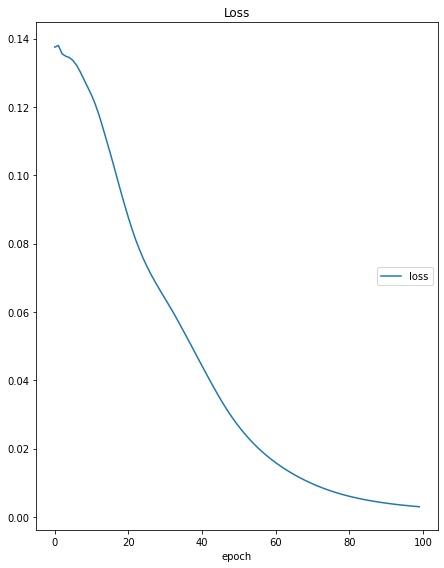

Loss
	loss             	 (min:    0.003, max:    0.138, cur:    0.003)
1/1 [==============================] - 0s 95ms/step
Test Set:
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])]
Prediction:
[0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
Model successfully trained.


In [3]:
int_model = get_integer_split_input_model(
        check=True,
        verbose=True,
        plot_losses=True
        )

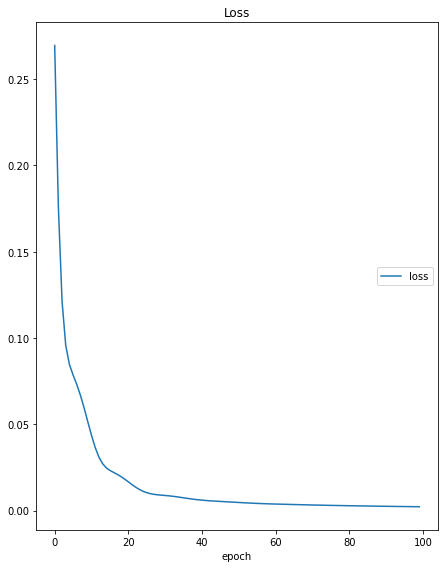

Loss
	loss             	 (min:    0.002, max:    0.270, cur:    0.002)
1/1 [==============================] - 0s 41ms/step
Test Set:
[array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32), array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
   

In [4]:
cat_model = get_categorical_split_input_model(
        check=True,
        verbose=True,
        plot_losses=True
        )

## Test Single Prediction

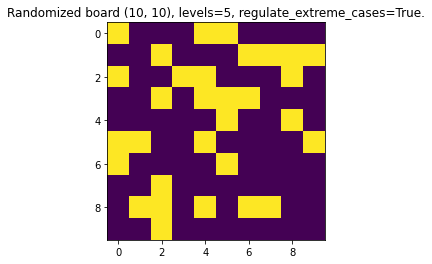

In [5]:
generate_board_shape = (10, 10)
rand_board = generate_board(
        generate_board_shape,
        padding=False,
        pad_value=0,
        levels=5,
        regulate_extreme_cases=True,
        show=True
        )

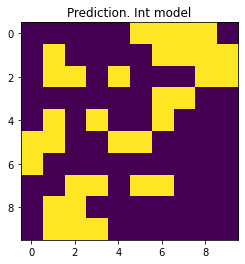

In [9]:
pred_board_int = predict_board(
    int_model, rand_board, title_context='Int model')

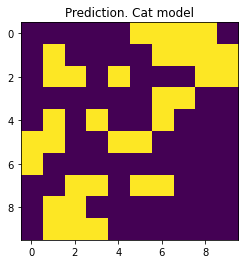

In [8]:
pred_board_cat = predict_board(
    cat_model, rand_board, categorical=True, title_context='Cat model')

## Test Chain Prediction

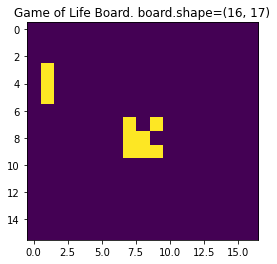

In [30]:
board = load_board(show=True)

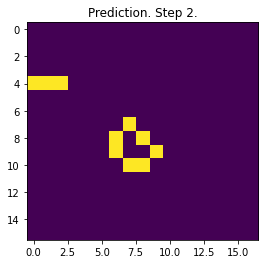

In [63]:
recursive_pred_board_int = pred_board_recursive(
    int_model, board, 3, show=True, title_context='Int model')

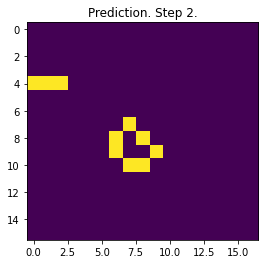

In [64]:
recursive_pred_board_cat = pred_board_recursive(
    cat_model, board, 3, show=True, categorical=True, title_context='Cat model')